# Homework 5: Adversarial Attacks and Defenses

Duke University

ECE661 Fall 2022

## Setup

You shouldn't have to change anything in these cells

In [5]:
from google.colab import drive
drive.mount('/content/googledrive', force_remount=True)

Mounted at /content/googledrive


In [6]:
%cd /content/googledrive/MyDrive/thwisha/ECE 661 HW 5

/content/googledrive/.shortcut-targets-by-id/1tAhXVoWUqHDDlpVqoIMq7KqGDFuefQUm/ECE 661 HW 5


In [7]:
!ls

attacks.py	 models.py			netA_advtrain_pgd0p1.pt     netB_standard.pt
data		 netA_advtrain_fgsm0p1.pt	“netA_advtrain_rfgsm0p1.pt  __pycache__
HWK5_main.ipynb  netA_advtrain_pgd0p1_e_0_2.pt	netA_standard.pt


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random

# Custom
import models
import attacks

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

device: cuda


In [9]:
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size = 64, shuffle=True, )
test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('./data', train=False, download=True, transform=transforms.ToTensor()),
    batch_size = 64, shuffle=False, )

In [10]:
def test_model(mdl, loader, device):
    mdl.eval()
    running_correct = 0.
    running_loss = 0.
    running_total = 0.
    with torch.no_grad():
        for batch_idx,(data,labels) in enumerate(loader):
            data = data.to(device); labels = labels.to(device)
            clean_outputs = mdl(data)
            clean_loss = F.cross_entropy(clean_outputs, labels)
            _,clean_preds = clean_outputs.max(1)
            running_correct += clean_preds.eq(labels).sum().item()
            running_loss += clean_loss.item()
            running_total += labels.size(0)
    clean_acc = running_correct/running_total
    clean_loss = running_loss/len(loader)
    mdl.train()
    return clean_acc,clean_loss

## Model training

Train a model and save the checkpoint. This cell is used in Lab-1 and Lab-3

In [ ]:
## Pick a model architecture
net = models.NetA().to(device)
#net = models.NetB().to(device)

## Checkpoint name for this model
model_checkpoint = "netA_standard.pt"
#model_checkpoint = "netB_standard.pt"

## Basic training params
num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

## Training Loop
for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device); labels = labels.to(device)

        # Forward pass
        outputs = net(data)
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)

    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    # Save model
    torch.save(net.state_dict(), model_checkpoint)

    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

Epoch: [ 0 / 20 ]; TrainAcc: 0.84708; TrainLoss: 0.42090; TestAcc: 0.89380; TestLoss: 0.30414
Epoch: [ 1 / 20 ]; TrainAcc: 0.90095; TrainLoss: 0.27119; TestAcc: 0.88780; TestLoss: 0.29210
Epoch: [ 2 / 20 ]; TrainAcc: 0.91605; TrainLoss: 0.22896; TestAcc: 0.90850; TestLoss: 0.25362
Epoch: [ 3 / 20 ]; TrainAcc: 0.92573; TrainLoss: 0.20112; TestAcc: 0.91210; TestLoss: 0.24762
Epoch: [ 4 / 20 ]; TrainAcc: 0.93535; TrainLoss: 0.17407; TestAcc: 0.91090; TestLoss: 0.24623
Epoch: [ 5 / 20 ]; TrainAcc: 0.94227; TrainLoss: 0.15506; TestAcc: 0.91000; TestLoss: 0.25595
Epoch: [ 6 / 20 ]; TrainAcc: 0.94945; TrainLoss: 0.13644; TestAcc: 0.91750; TestLoss: 0.25273
Epoch: [ 7 / 20 ]; TrainAcc: 0.95573; TrainLoss: 0.11925; TestAcc: 0.91360; TestLoss: 0.28425
Epoch: [ 8 / 20 ]; TrainAcc: 0.96170; TrainLoss: 0.10307; TestAcc: 0.91670; TestLoss: 0.28388
Epoch: [ 9 / 20 ]; TrainAcc: 0.96528; TrainLoss: 0.09259; TestAcc: 0.90990; TestLoss: 0.30589
Epoch: [ 10 / 20 ]; TrainAcc: 0.97107; TrainLoss: 0.07833; T

In [ ]:
## Pick a model architecture
#net = models.NetA().to(device)
net = models.NetB().to(device)

## Checkpoint name for this model
#model_checkpoint = "netA_standard.pt"
model_checkpoint = "netB_standard.pt"

## Basic training params
num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

## Training Loop
for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device); labels = labels.to(device)

        # Forward pass
        outputs = net(data)
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)

    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    # Save model
    torch.save(net.state_dict(), model_checkpoint)

    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

Epoch: [ 0 / 20 ]; TrainAcc: 0.84858; TrainLoss: 0.41644; TestAcc: 0.89090; TestLoss: 0.30088
Epoch: [ 1 / 20 ]; TrainAcc: 0.90695; TrainLoss: 0.25946; TestAcc: 0.90030; TestLoss: 0.27491
Epoch: [ 2 / 20 ]; TrainAcc: 0.92070; TrainLoss: 0.21854; TestAcc: 0.91380; TestLoss: 0.24165
Epoch: [ 3 / 20 ]; TrainAcc: 0.93095; TrainLoss: 0.18941; TestAcc: 0.91860; TestLoss: 0.22607
Epoch: [ 4 / 20 ]; TrainAcc: 0.93947; TrainLoss: 0.16796; TestAcc: 0.92250; TestLoss: 0.22431
Epoch: [ 5 / 20 ]; TrainAcc: 0.94732; TrainLoss: 0.14746; TestAcc: 0.92120; TestLoss: 0.22564
Epoch: [ 6 / 20 ]; TrainAcc: 0.95213; TrainLoss: 0.12916; TestAcc: 0.92140; TestLoss: 0.24359
Epoch: [ 7 / 20 ]; TrainAcc: 0.95875; TrainLoss: 0.11467; TestAcc: 0.92220; TestLoss: 0.24376
Epoch: [ 8 / 20 ]; TrainAcc: 0.96368; TrainLoss: 0.10033; TestAcc: 0.92010; TestLoss: 0.26321
Epoch: [ 9 / 20 ]; TrainAcc: 0.96863; TrainLoss: 0.08535; TestAcc: 0.92170; TestLoss: 0.29607
Epoch: [ 10 / 20 ]; TrainAcc: 0.97192; TrainLoss: 0.07647; T

**Visualize some perturbed samples**

##Question 1 (b)



Epsilon value to 0.0



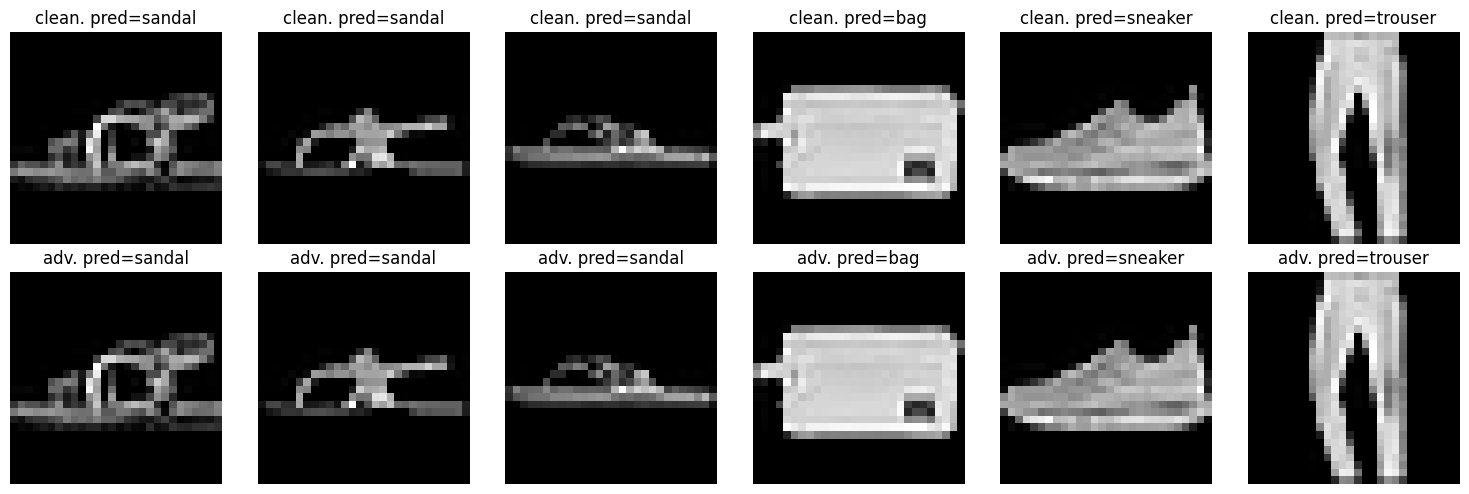



Epsilon value to 0.003



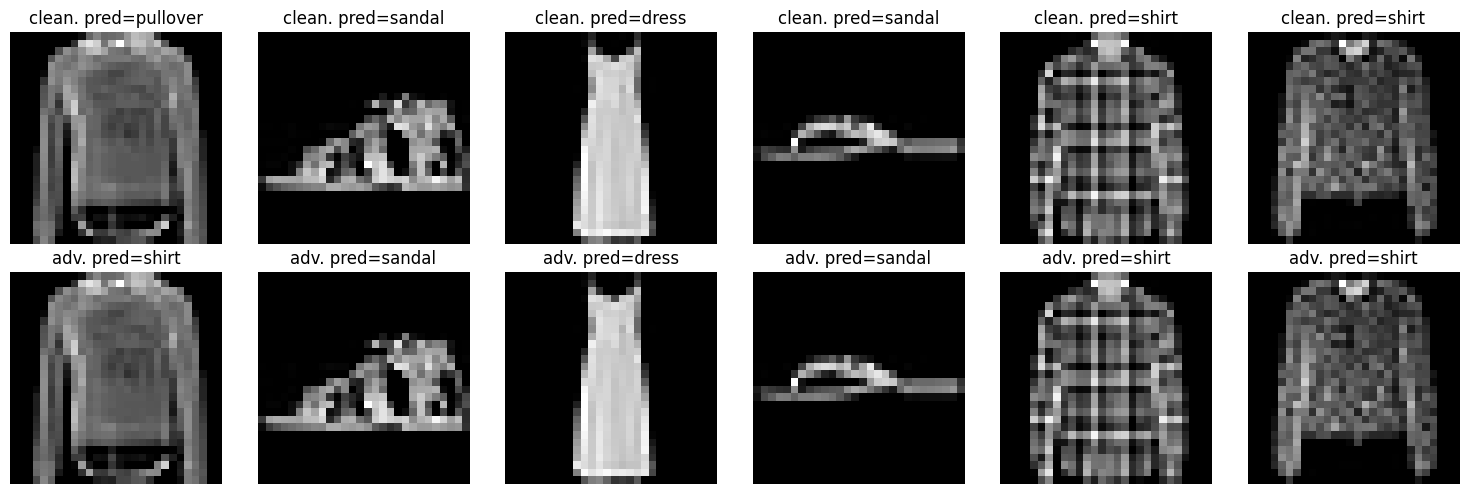



Epsilon value to 0.05



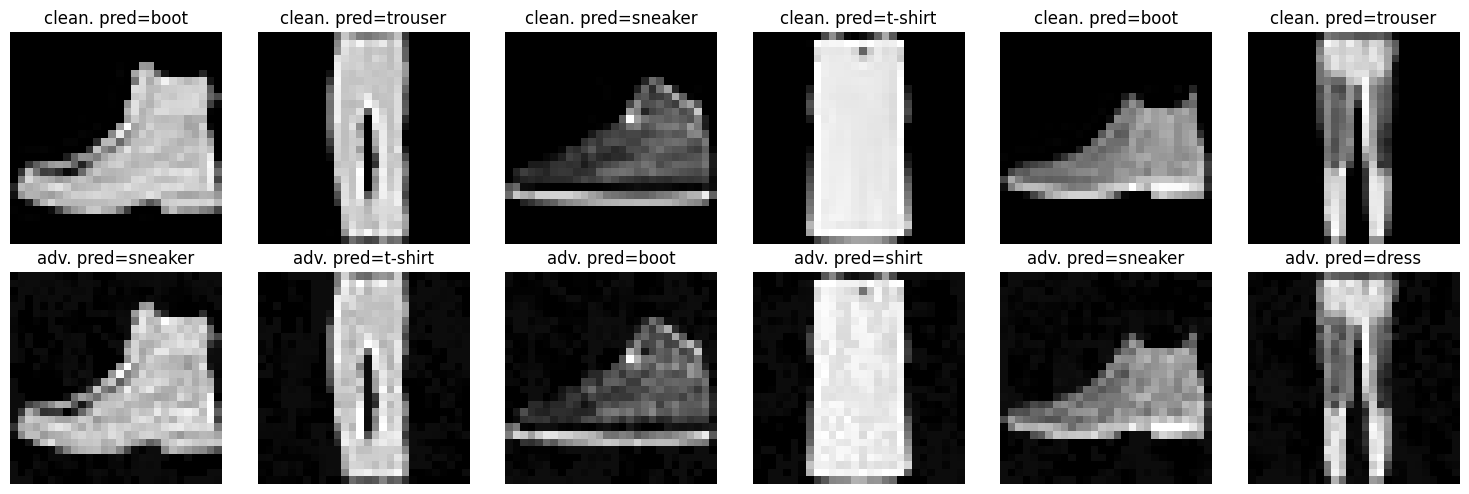



Epsilon value to 0.1



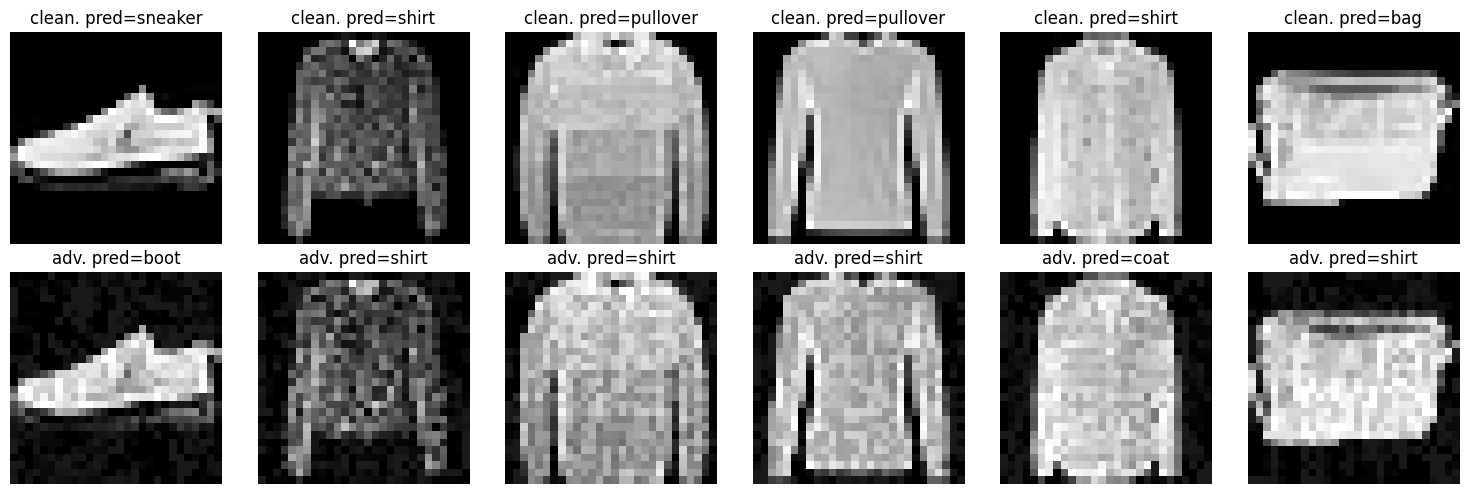



Epsilon value to 0.15



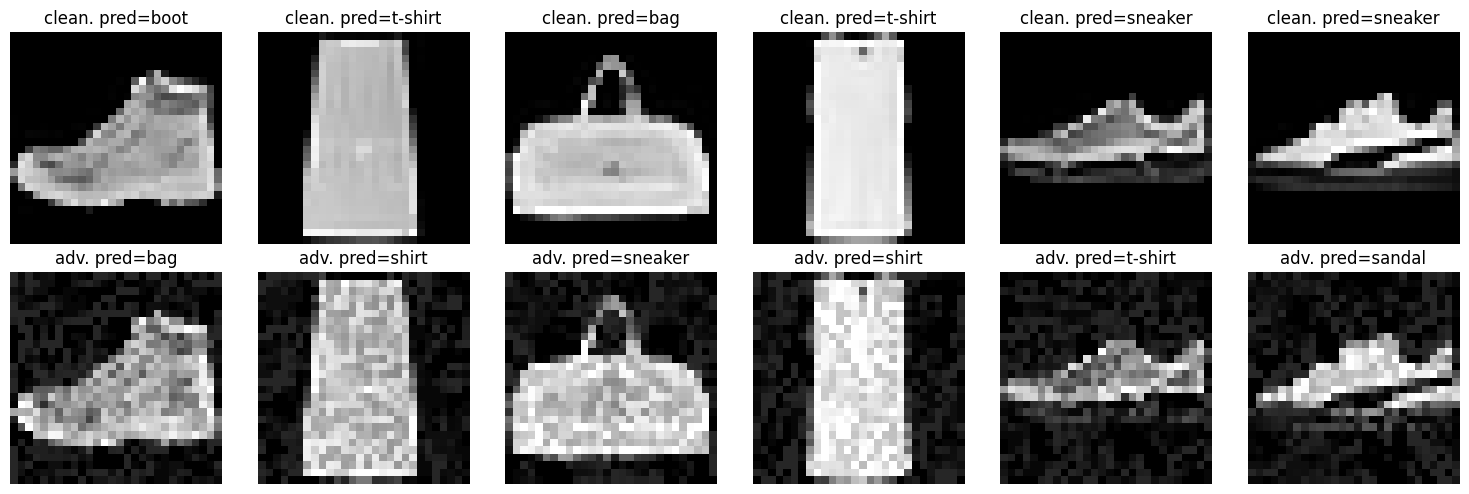



Epsilon value to 0.2



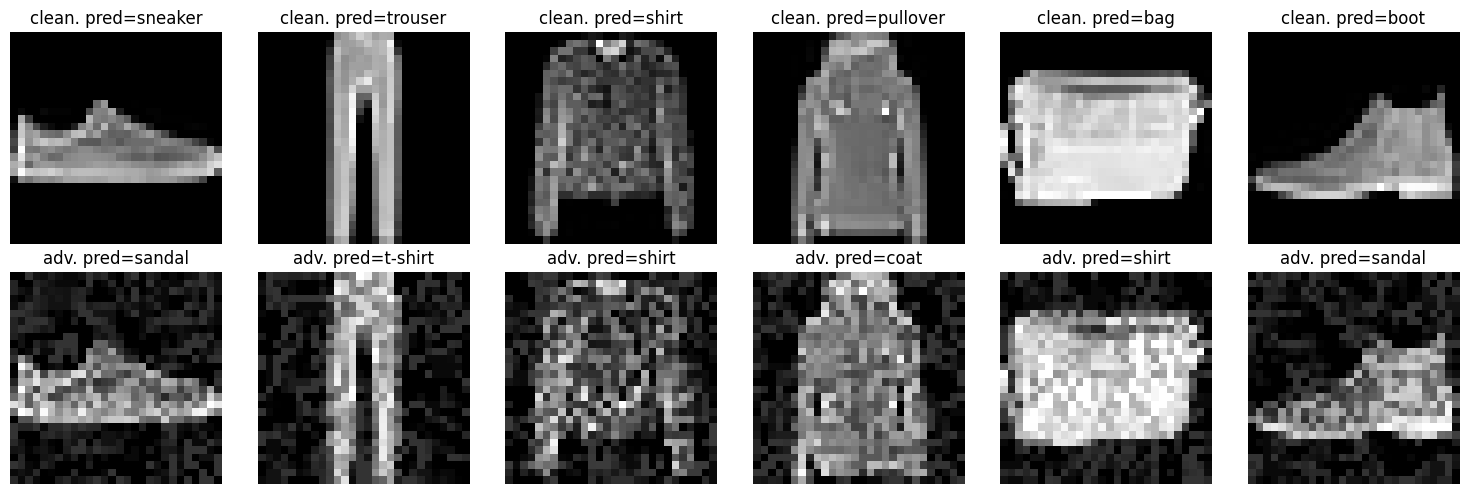

In [ ]:
classes = ["t-shirt", "trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","boot"]

# Assuming the PGD_attack function is defined and test_loader is available

# Instantiate the NetA model and load the pre-trained weights
net = models.NetA().to(device)
net.load_state_dict(torch.load("netA_standard.pt"))

# Define epsilon values in the range [0.0, 0.2]
epsilon_values = [0.0, 0.003, 0.05, 0.1, 0.15, 0.2]

# Iterate over different epsilon values
for EPS in epsilon_values:
    # Define the adversarial parameters based on EPS
    print("\n")
    print(f"Epsilon value to {EPS}\n")
    ITS = 10
    ALP = 1.85 * (EPS / ITS)

    # Iterate over the test loader
    for data, labels in test_loader:
        data = data.to(device)
        labels = labels.to(device)

        # Compute and apply adversarial perturbation to data using PGD_attack
        adv_data = attacks.PGD_attack(net, device, data, labels, EPS, ALP, ITS, True)

        # Compute predictions
        with torch.no_grad():
            clean_outputs = net(data)
            _, clean_preds = clean_outputs.max(1)
            clean_preds = clean_preds.cpu().squeeze().numpy()

            adv_outputs = net(adv_data)
            _, adv_preds = adv_outputs.max(1)
            adv_preds = adv_preds.cpu().squeeze().numpy()

        # Plot some samples
        inds = random.sample(list(range(data.size(0))), 6)
        plt.figure(figsize=(15, 5))

        for jj in range(6):
            plt.subplot(2, 6, jj + 1)
            plt.imshow(data[inds[jj], 0].cpu().numpy(), cmap='gray')
            plt.axis("off")
            plt.title("clean. pred={}".format(classes[clean_preds[inds[jj]]]))

        for jj in range(6):
            plt.subplot(2, 6, 6 + jj + 1)
            plt.imshow(adv_data[inds[jj], 0].cpu().numpy(), cmap='gray')
            plt.axis("off")
            plt.title("adv. pred={}".format(classes[adv_preds[inds[jj]]]))

        plt.tight_layout()
        plt.show()
        break


## Question 1(c)

## FGSM



Epsilon value to 0.003



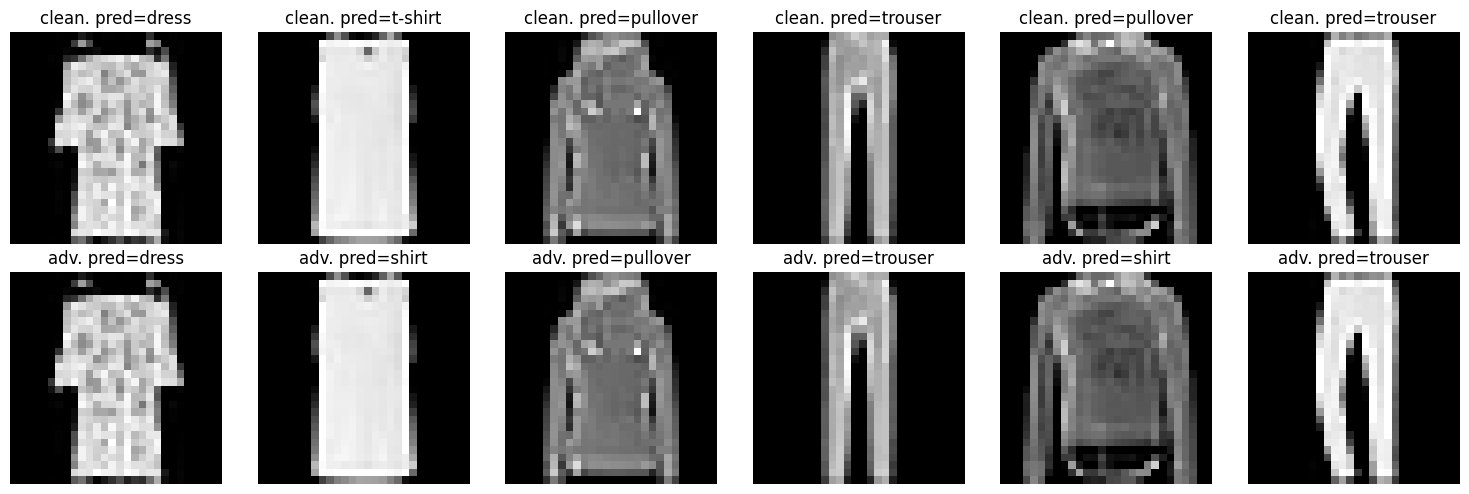



Epsilon value to 0.05



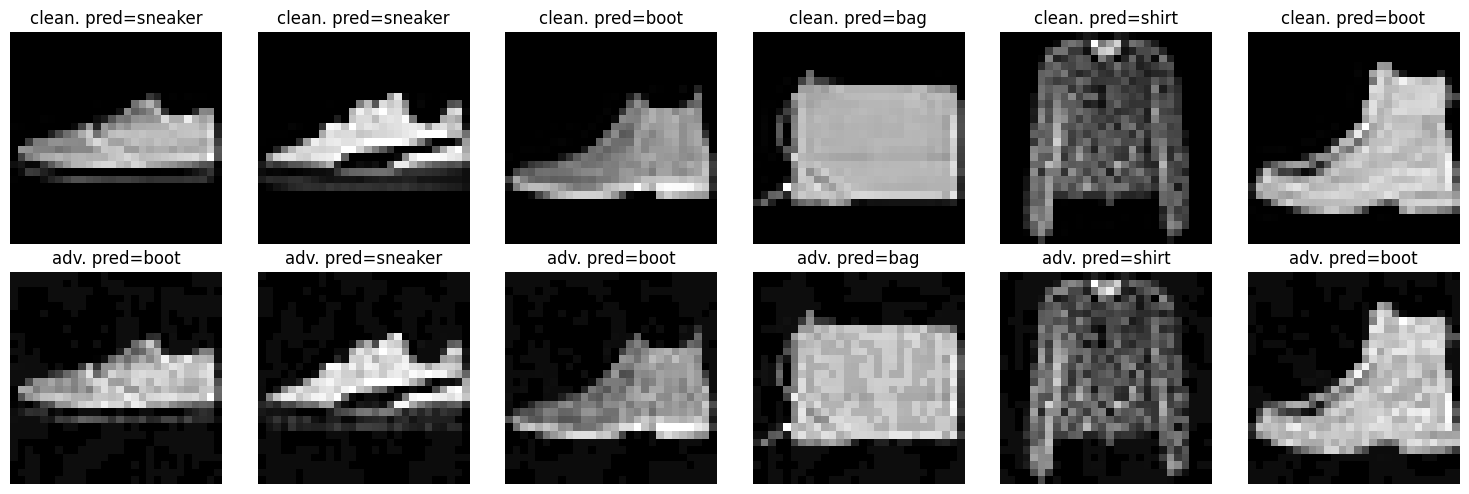



Epsilon value to 0.1



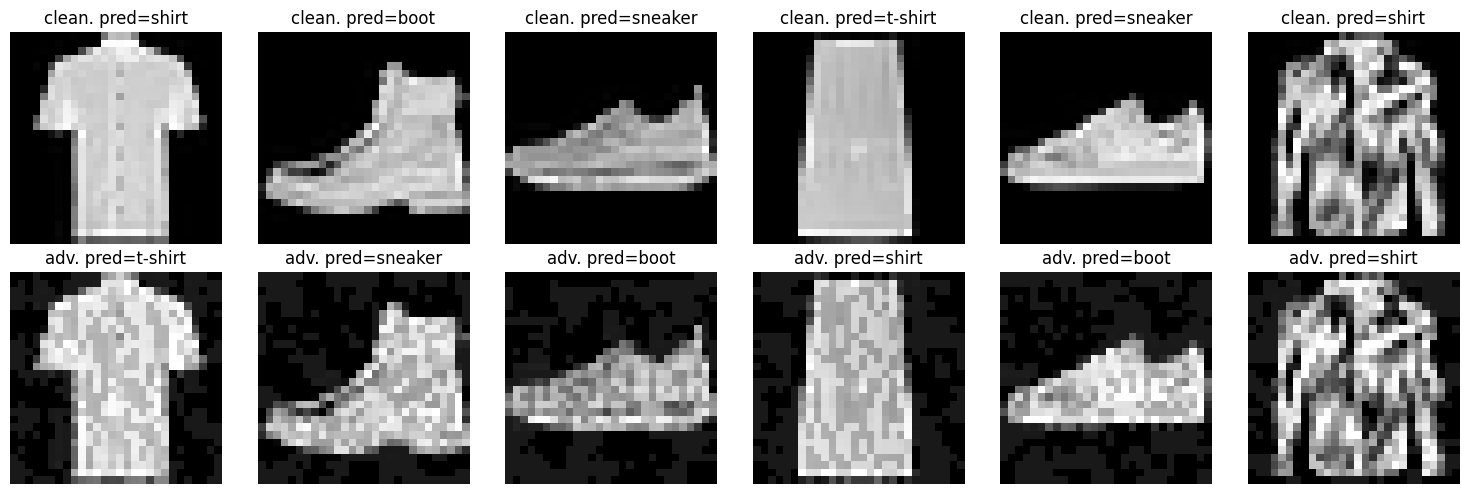



Epsilon value to 0.15



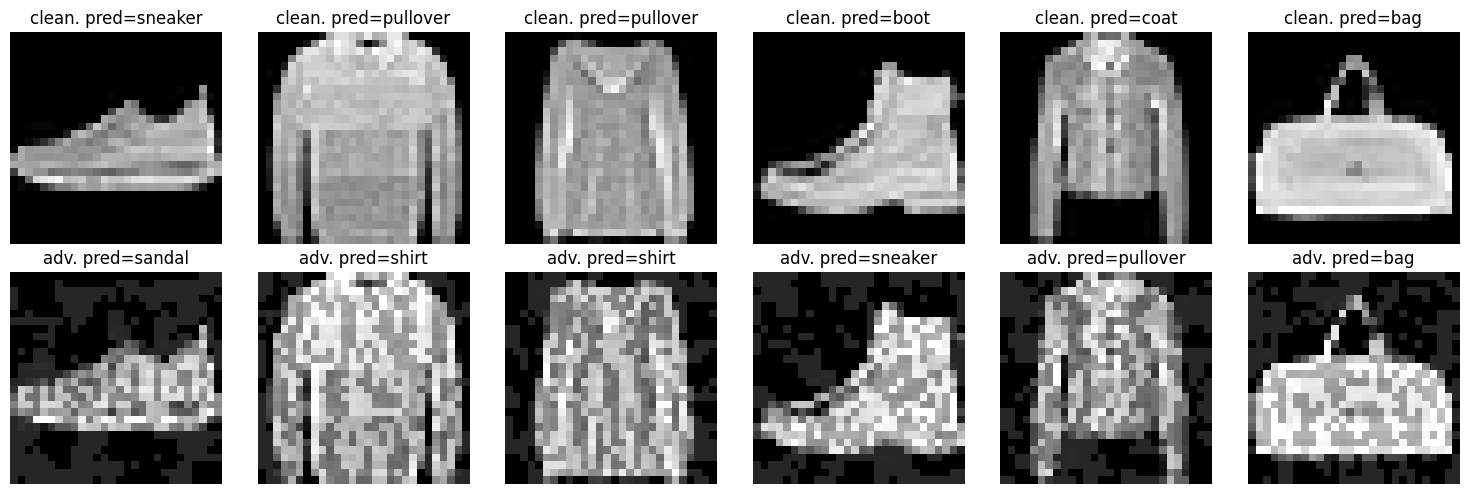



Epsilon value to 0.2



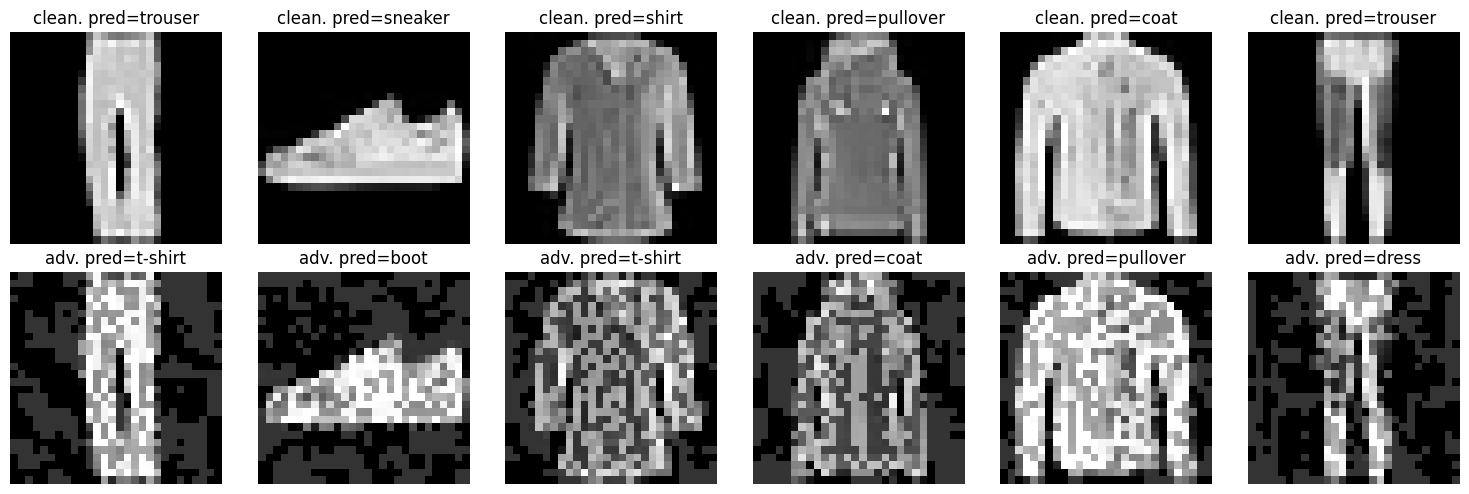

In [ ]:
classes = ["t-shirt", "trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","boot"]

# Assuming the PGD_attack function is defined and test_loader is available

# Instantiate the NetA model and load the pre-trained weights
net = models.NetA().to(device)
net.load_state_dict(torch.load("netA_standard.pt"))

# Define epsilon values in the range [0.0, 0.2]
epsilon_values = [0.003, 0.05, 0.1, 0.15, 0.2]

# Iterate over different epsilon values
for EPS in epsilon_values:
    # Define the adversarial parameters based on EPS
    print("\n")
    print(f"Epsilon value to {EPS}\n")
    ITS = 10
    ALP = 1.85 * (EPS / ITS)

    # Iterate over the test loader
    for data, labels in test_loader:
        data = data.to(device)
        labels = labels.to(device)

        # Compute and apply adversarial perturbation to data using PGD_attack
        adv_data = attacks.FGSM_attack(net, device, data, labels, EPS)

        # Compute predictions
        with torch.no_grad():
            clean_outputs = net(data)
            _, clean_preds = clean_outputs.max(1)
            clean_preds = clean_preds.cpu().squeeze().numpy()

            adv_outputs = net(adv_data)
            _, adv_preds = adv_outputs.max(1)
            adv_preds = adv_preds.cpu().squeeze().numpy()

        # Plot some samples
        inds = random.sample(list(range(data.size(0))), 6)
        plt.figure(figsize=(15, 5))

        for jj in range(6):
            plt.subplot(2, 6, jj + 1)
            plt.imshow(data[inds[jj], 0].cpu().numpy(), cmap='gray')
            plt.axis("off")
            plt.title("clean. pred={}".format(classes[clean_preds[inds[jj]]]))

        for jj in range(6):
            plt.subplot(2, 6, 6 + jj + 1)
            plt.imshow(adv_data[inds[jj], 0].cpu().numpy(), cmap='gray')
            plt.axis("off")
            plt.title("adv. pred={}".format(classes[adv_preds[inds[jj]]]))

        plt.tight_layout()
        plt.show()
        break


## rFSGM



Epsilon value to 0.003



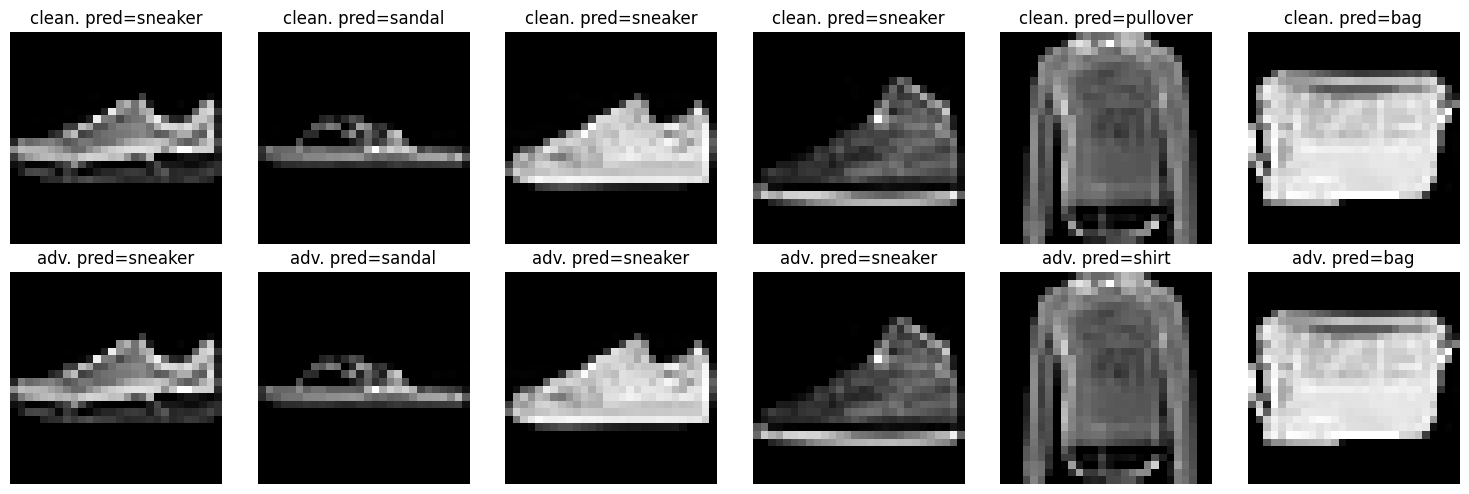



Epsilon value to 0.05



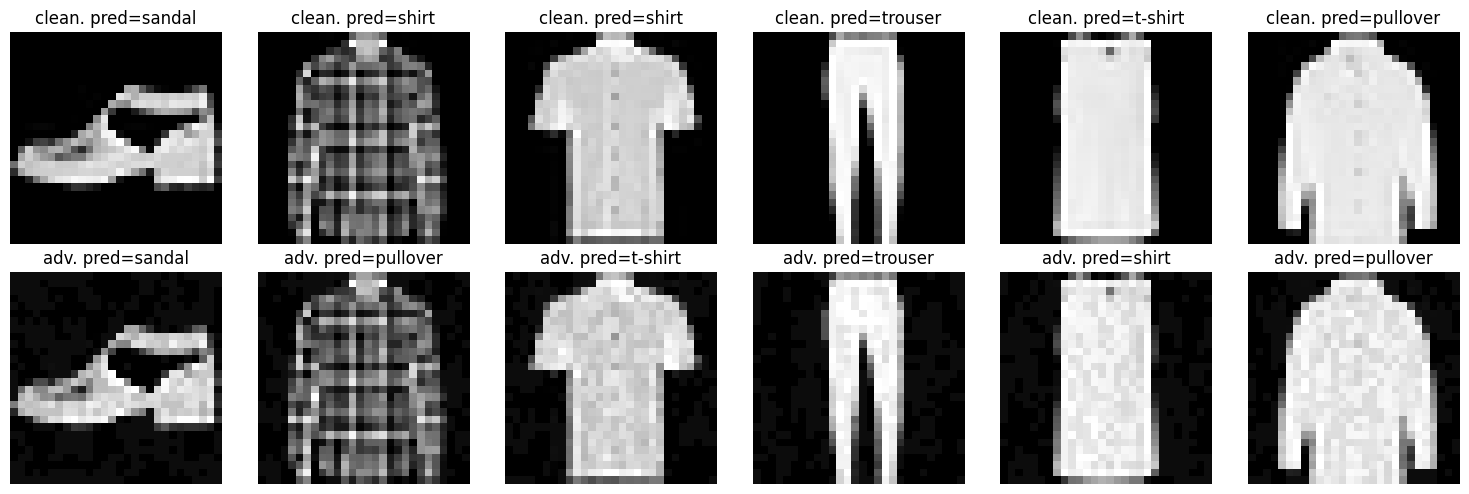



Epsilon value to 0.1



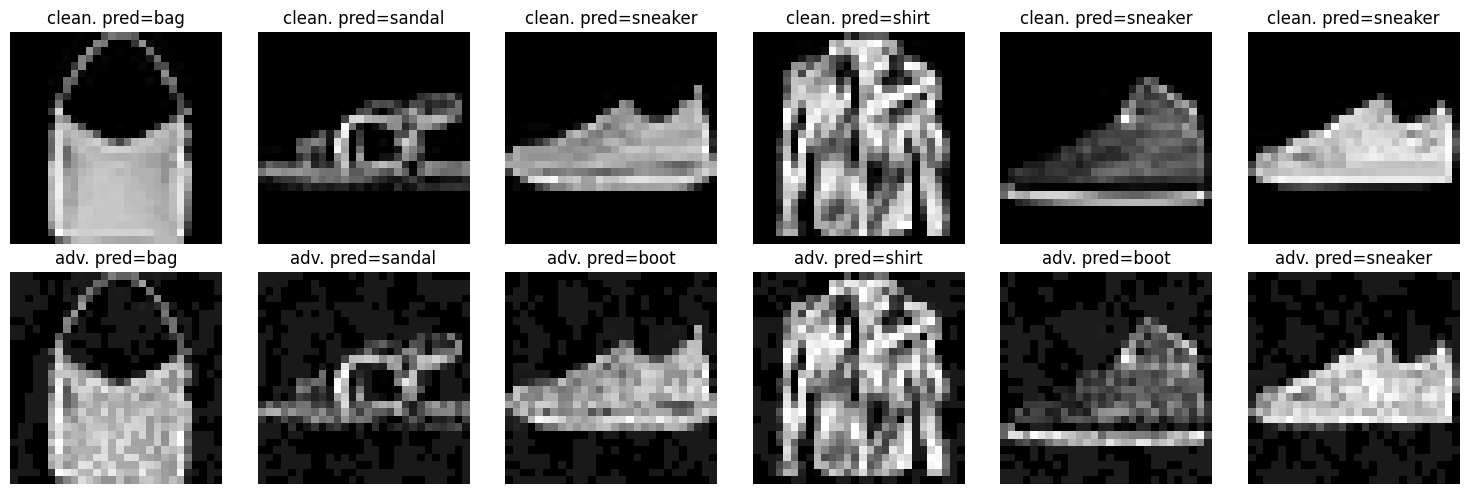



Epsilon value to 0.15



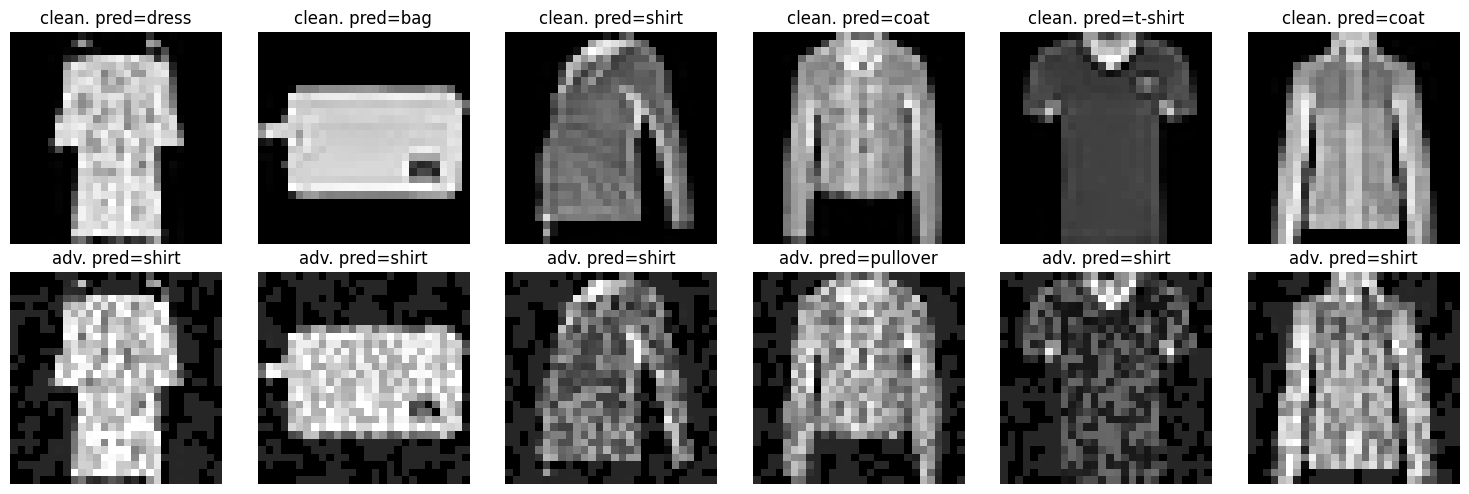



Epsilon value to 0.2



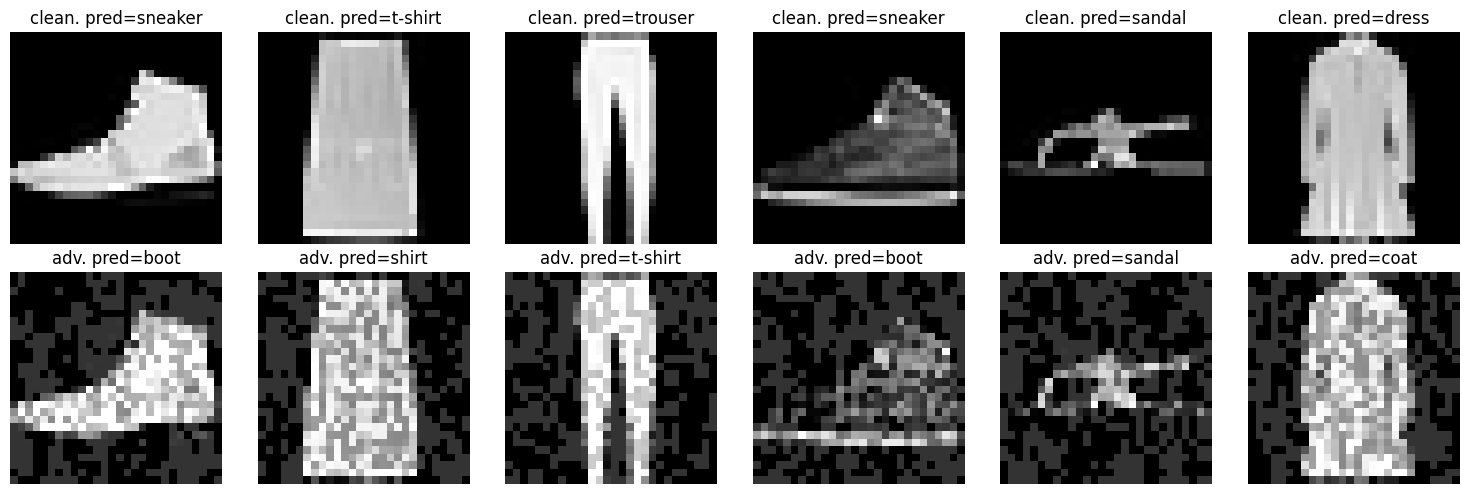

In [ ]:
classes = ["t-shirt", "trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","boot"]

# Assuming the PGD_attack function is defined and test_loader is available

# Instantiate the NetA model and load the pre-trained weights
net = models.NetA().to(device)
net.load_state_dict(torch.load("netA_standard.pt"))

# Define epsilon values in the range [0.0, 0.2]
epsilon_values = [0.003, 0.05, 0.1, 0.15, 0.2]

# Iterate over different epsilon values
for EPS in epsilon_values:
    # Define the adversarial parameters based on EPS
    print("\n")
    print(f"Epsilon value to {EPS}\n")
    ITS = 10
    ALP = 1.85 * (EPS / ITS)

    # Iterate over the test loader
    for data, labels in test_loader:
        data = data.to(device)
        labels = labels.to(device)

        # Compute and apply adversarial perturbation to data using PGD_attack
        adv_data = attacks.rFGSM_attack(net, device, data, labels, EPS)

        # Compute predictions
        with torch.no_grad():
            clean_outputs = net(data)
            _, clean_preds = clean_outputs.max(1)
            clean_preds = clean_preds.cpu().squeeze().numpy()

            adv_outputs = net(adv_data)
            _, adv_preds = adv_outputs.max(1)
            adv_preds = adv_preds.cpu().squeeze().numpy()

        # Plot some samples
        inds = random.sample(list(range(data.size(0))), 6)
        plt.figure(figsize=(15, 5))

        for jj in range(6):
            plt.subplot(2, 6, jj + 1)
            plt.imshow(data[inds[jj], 0].cpu().numpy(), cmap='gray')
            plt.axis("off")
            plt.title("clean. pred={}".format(classes[clean_preds[inds[jj]]]))

        for jj in range(6):
            plt.subplot(2, 6, 6 + jj + 1)
            plt.imshow(adv_data[inds[jj], 0].cpu().numpy(), cmap='gray')
            plt.axis("off")
            plt.title("adv. pred={}".format(classes[adv_preds[inds[jj]]]))

        plt.tight_layout()
        plt.show()
        break




Epsilon value to 0.0



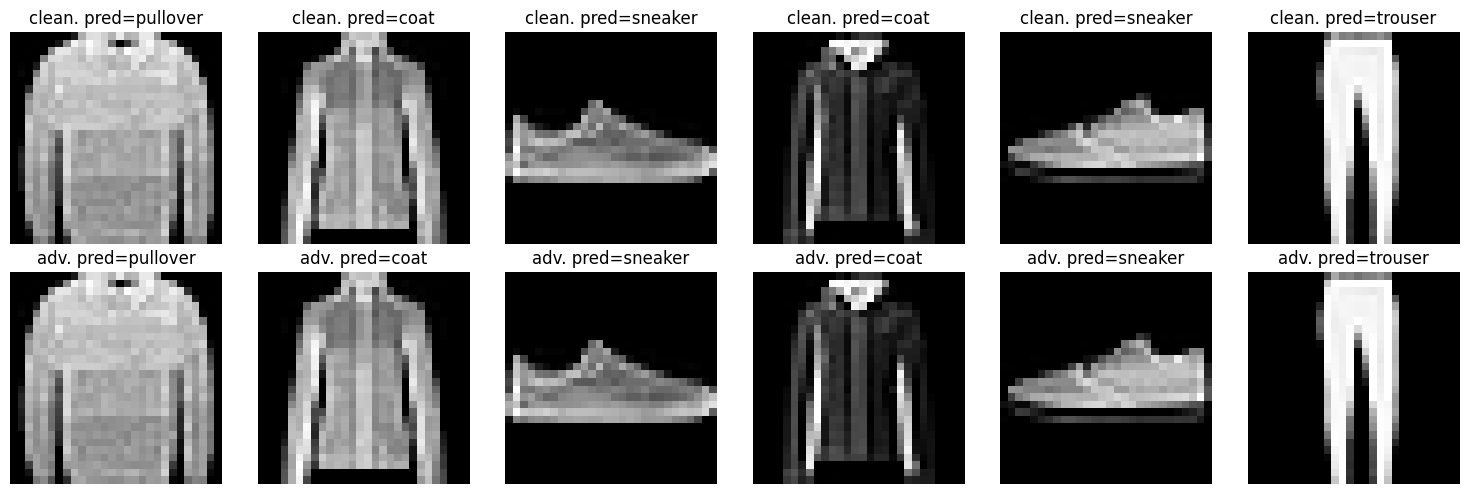



Epsilon value to 0.2



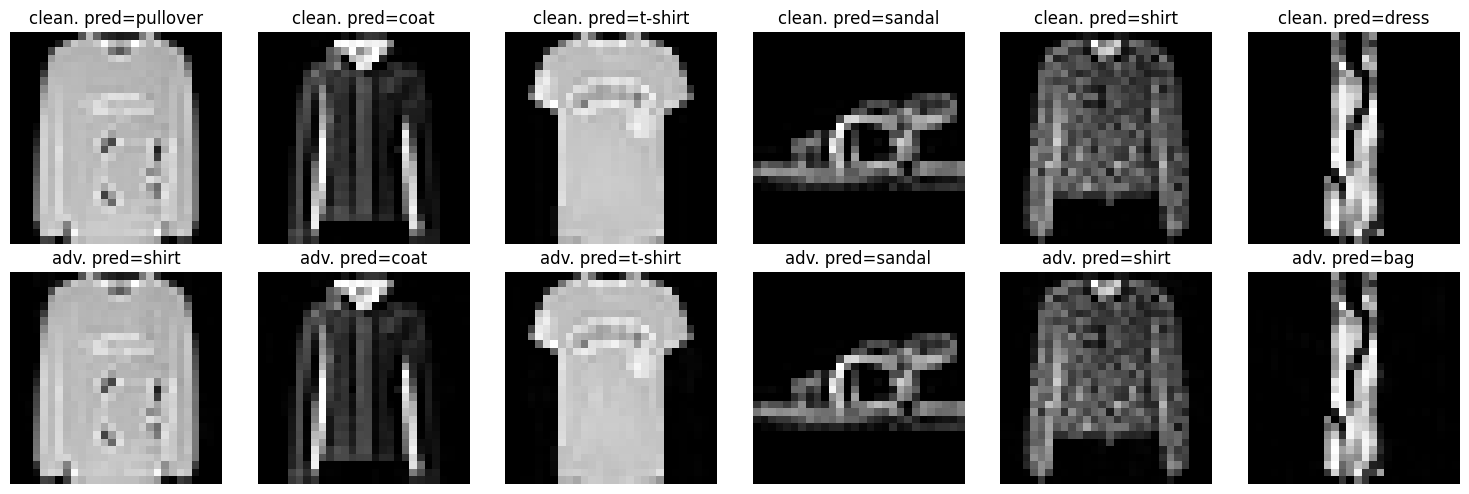



Epsilon value to 0.5



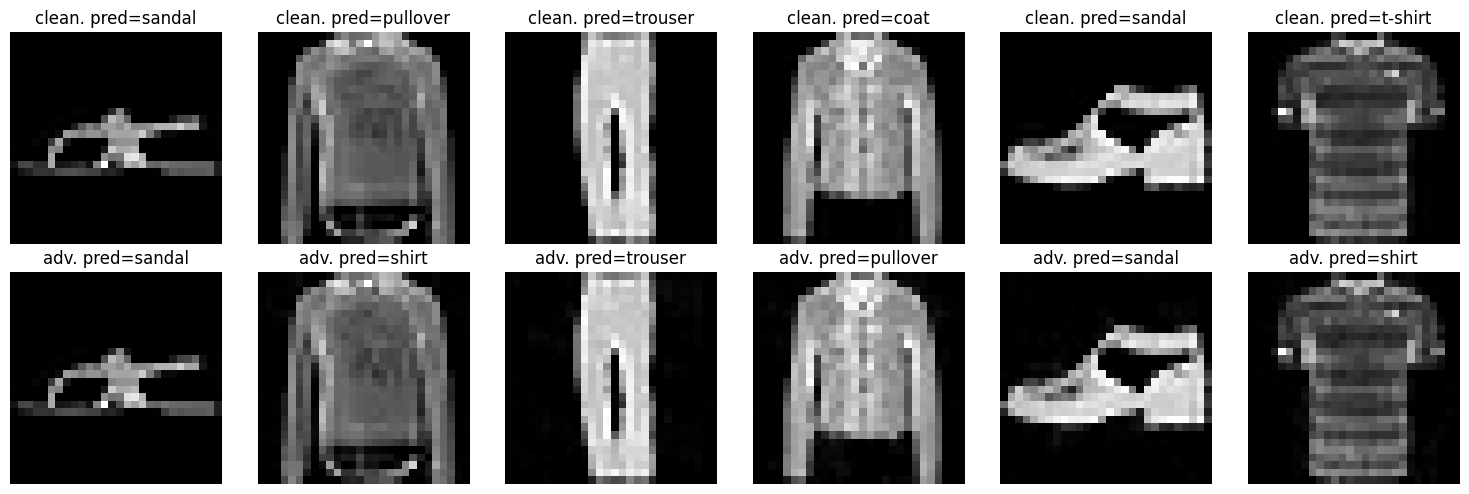



Epsilon value to 1



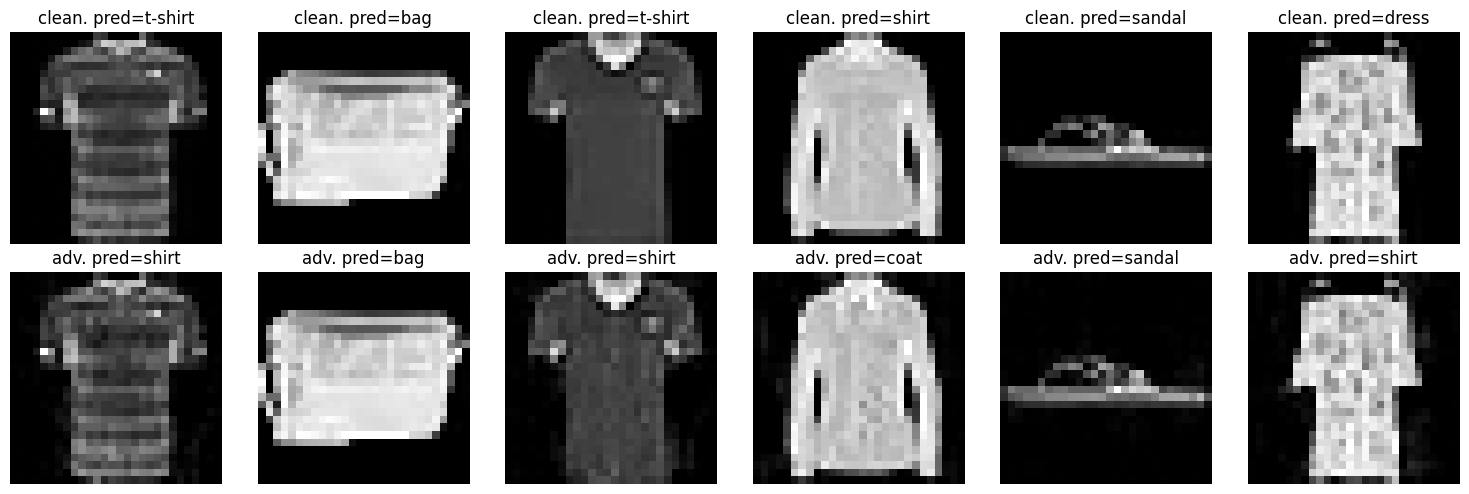



Epsilon value to 2



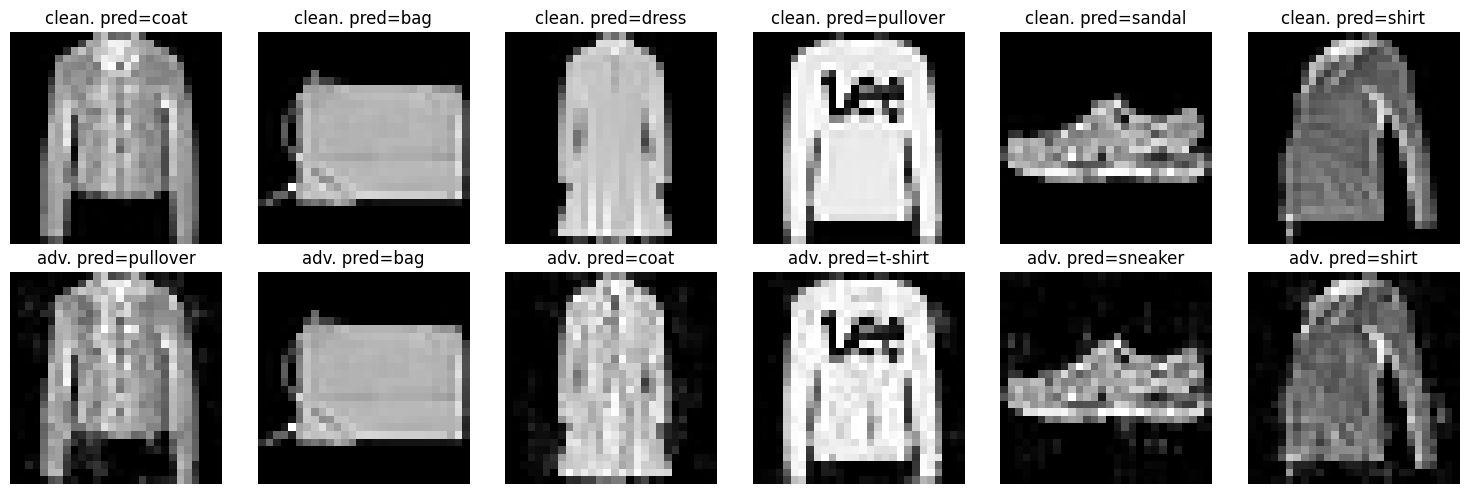



Epsilon value to 3



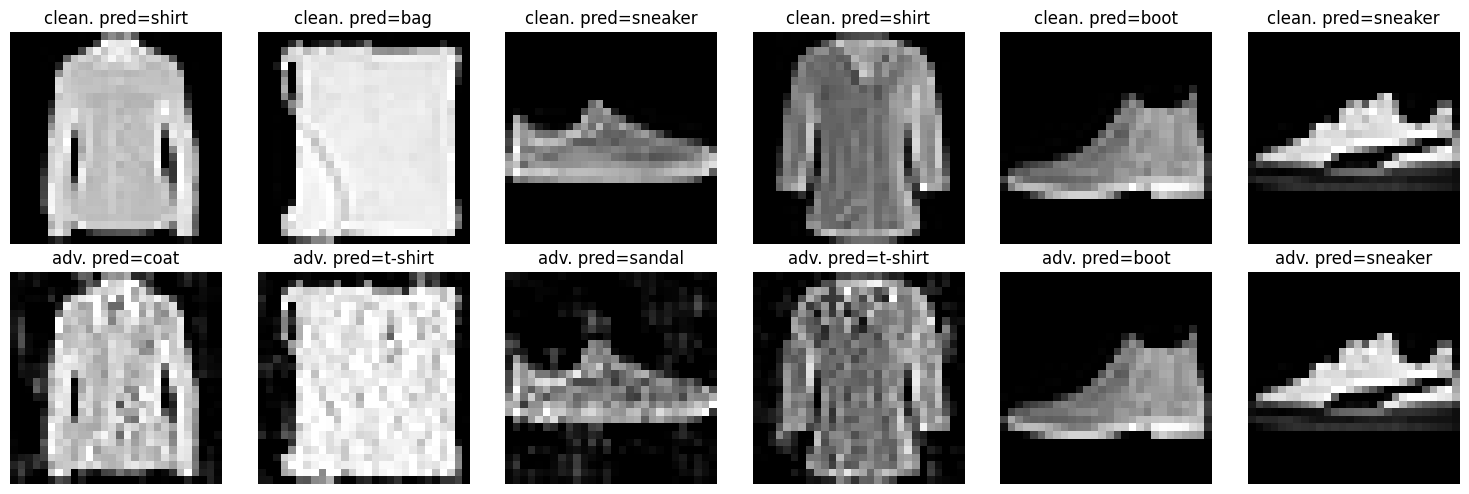



Epsilon value to 4



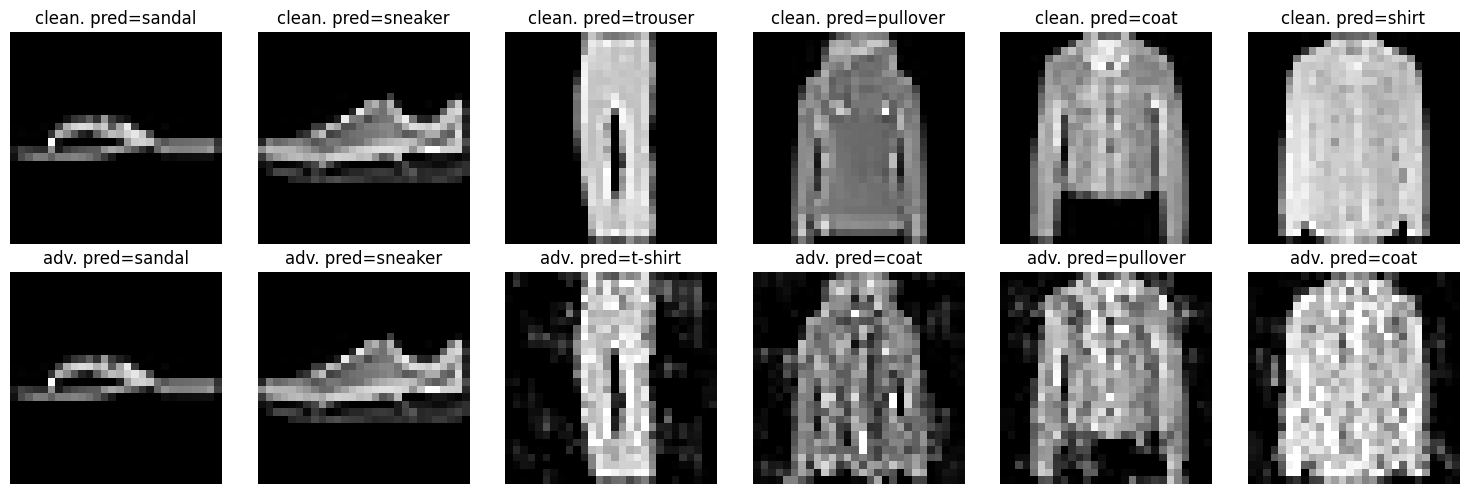

In [ ]:
classes = ["t-shirt", "trouser","pullover","dress","coat","sandal","shirt","sneaker","bag","boot"]

# Assuming the PGD_attack function is defined and test_loader is available

# Instantiate the NetA model and load the pre-trained weights
net = models.NetA().to(device)
net.load_state_dict(torch.load("netA_standard.pt"))

# Define epsilon values in the range [0.0, 0.2]
epsilon_values = [0.0,0.2, 0.5, 1, 2, 3, 4]

# Iterate over different epsilon values
for EPS in epsilon_values:
    # Define the adversarial parameters based on EPS
    print("\n")
    print(f"Epsilon value to {EPS}\n")
    ITS = 10
    ALP = 1.85 * (EPS / ITS)

    # Iterate over the test loader
    for data, labels in test_loader:
        data = data.to(device)
        labels = labels.to(device)

        # Compute and apply adversarial perturbation to data using PGD_attack
        adv_data = attacks.FGM_L2_attack(net, device, data, labels, EPS)

        # Compute predictions
        with torch.no_grad():
            clean_outputs = net(data)
            _, clean_preds = clean_outputs.max(1)
            clean_preds = clean_preds.cpu().squeeze().numpy()

            adv_outputs = net(adv_data)
            _, adv_preds = adv_outputs.max(1)
            adv_preds = adv_preds.cpu().squeeze().numpy()

        # Plot some samples
        inds = random.sample(list(range(data.size(0))), 6)
        plt.figure(figsize=(15, 5))

        for jj in range(6):
            plt.subplot(2, 6, jj + 1)
            plt.imshow(data[inds[jj], 0].cpu().numpy(), cmap='gray')
            plt.axis("off")
            plt.title("clean. pred={}".format(classes[clean_preds[inds[jj]]]))

        for jj in range(6):
            plt.subplot(2, 6, 6 + jj + 1)
            plt.imshow(adv_data[inds[jj], 0].cpu().numpy(), cmap='gray')
            plt.axis("off")
            plt.title("adv. pred={}".format(classes[adv_preds[inds[jj]]]))

        plt.tight_layout()
        plt.show()
        break


## Test Attacks - Whitebox & Blackbox

Don't forget to plot accuracy vs. epsilon curves!

In [ ]:
## Load pretrained models
whitebox = models.NetA()
blackbox = models.NetB()

whitebox.load_state_dict(torch.load("netA_standard.pt")) # TODO
blackbox.load_state_dict(torch.load("netB_standard.pt")) # TODO

whitebox = whitebox.to(device); blackbox = blackbox.to(device)
whitebox.eval(); blackbox.eval()

test_acc,_ = test_model(whitebox,test_loader,device)
print("Initial Accuracy of Whitebox Model: ",test_acc)
test_acc,_ = test_model(blackbox,test_loader,device)
print("Initial Accuracy of Blackbox Model: ",test_acc)

Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.9284


In [ ]:
def testing_different_attack(ATK_EPS,attack):
  ## Load pretrained models
  whitebox = models.NetA()
  blackbox = models.NetB()

  whitebox.load_state_dict(torch.load("netA_standard.pt")) # TODO
  blackbox.load_state_dict(torch.load("netB_standard.pt")) # TODO

  whitebox = whitebox.to(device); blackbox = blackbox.to(device)
  whitebox.eval(); blackbox.eval()

  test_acc,_ = test_model(whitebox,test_loader,device)
  print("Initial Accuracy of Whitebox Model: ",test_acc)
  test_acc,_ = test_model(blackbox,test_loader,device)
  print("Initial Accuracy of Blackbox Model: ",test_acc)

  ## Test the models against an adversarial attack

  # TODO: Set attack parameters here
  ATK_ITERS = 10
  ATK_ALPHA = 1.85*(ATK_EPS/ATK_ITERS)

  whitebox_correct = 0.
  blackbox_correct = 0.
  running_total = 0.
  for batch_idx,(data,labels) in enumerate(test_loader):
      data = data.to(device)
      labels = labels.to(device)

      # TODO: Perform adversarial attack here
      if attack == 'random_noise':
        adv_data = attacks.random_noise_attack(whitebox,device,data,ATK_EPS)
      elif attack == 'FGSM':
        adv_data = attacks.FGSM_attack(whitebox,device,data,labels,ATK_EPS)
      elif attack == 'rFGSM':
        adv_data = attacks.rFGSM_attack(whitebox,device,data,labels,ATK_EPS)
      elif attack == 'PGD':
        adv_data = attacks.PGD_attack(model=whitebox, device=device, dat=data, lbl=labels, eps=ATK_EPS, alpha=ATK_ALPHA, iters=ATK_ITERS, rand_start=True)

      # Sanity checking if adversarial example is "legal"
      assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
      assert(adv_data.max() == 1.)
      assert(adv_data.min() == 0.)

      # Compute accuracy on perturbed data
      with torch.no_grad():
          # Stat keeping - whitebox
          whitebox_outputs = whitebox(adv_data)
          _,whitebox_preds = whitebox_outputs.max(1)
          whitebox_correct += whitebox_preds.eq(labels).sum().item()
          # Stat keeping - blackbox
          blackbox_outputs = blackbox(adv_data)
          _,blackbox_preds = blackbox_outputs.max(1)
          blackbox_correct += blackbox_preds.eq(labels).sum().item()
          running_total += labels.size(0)



  # Print final
  whitebox_acc = whitebox_correct/running_total
  blackbox_acc = blackbox_correct/running_total

  print("Attack Epsilon: {}; Whitebox Accuracy: {}; Blackbox Accuracy: {}".format(ATK_EPS, whitebox_acc, blackbox_acc))

  print("Done!")

  return whitebox_acc, blackbox_acc

In [ ]:
print("Whitebox and Blackbox Accuracies for different epsilons for RANDOM NOISE\n")
epsilon_values = np.linspace(0,0.1,11)
whitebox_Random = []
blackbox_Random= []
for eps in epsilon_values:
  whitebox_acc,blackbox_acc = testing_different_attack(eps,'random_noise')
  whitebox_Random.append(whitebox_acc)
  blackbox_Random.append(blackbox_acc)

Whitebox and Blackbox Accuracies for different epsilons for RANDOM NOISE

Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.9284
Attack Epsilon: 0.0; Whitebox Accuracy: 0.9225; Blackbox Accuracy: 0.9284
Done!
Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.9284
Attack Epsilon: 0.01; Whitebox Accuracy: 0.922; Blackbox Accuracy: 0.9269
Done!
Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.9284
Attack Epsilon: 0.02; Whitebox Accuracy: 0.9216; Blackbox Accuracy: 0.9254
Done!
Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.9284
Attack Epsilon: 0.03; Whitebox Accuracy: 0.9209; Blackbox Accuracy: 0.9213
Done!
Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.9284
Attack Epsilon: 0.04; Whitebox Accuracy: 0.9172; Blackbox Accuracy: 0.9172
Done!
Initial Accuracy of Whitebox Model:  0.9225
Initial Accuracy of Blackbox Model:  0.

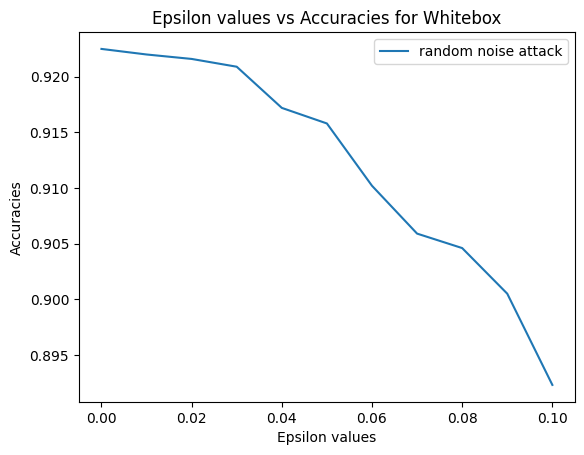

In [ ]:
plt.plot(epsilon_values, whitebox_Random,label = 'random noise attack')
plt.xlabel('Epsilon values')
plt.ylabel('Accuracies')
plt.title('Epsilon values vs Accuracies for Whitebox')
plt.legend()
plt.show()

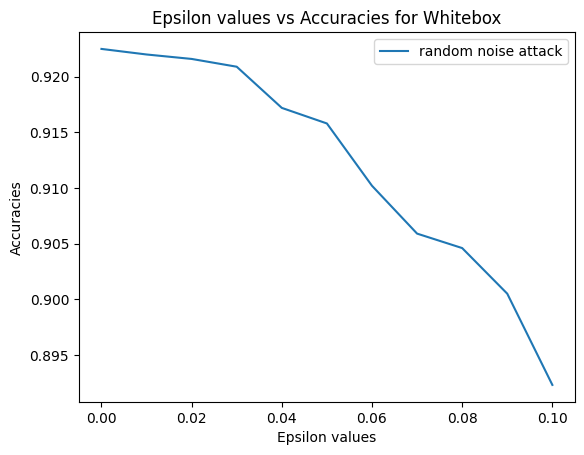

In [ ]:
plt.plot(epsilon_values, whitebox_Random,label = 'random noise attack')
plt.xlabel('Epsilon values')
plt.ylabel('Accuracies')
plt.title('Epsilon values vs Accuracies for Whitebox')
plt.legend()
plt.show()

In [ ]:
print("Whitebox and Blackbox Accuracies for different epsilons for PGD\n")
epsilon_values = np.linspace(0,0.1,11)
whitebox_PGD = []
blackbox_PGD= []
for eps in epsilon_values:
  whitebox_acc,blackbox_acc = testing_different_attack(eps,'PGD')
  whitebox_PGD.append(whitebox_acc)
  blackbox_PGD.append(blackbox_acc)

Whitebox and Blackbox Accuracies for different epsilons for PGD

Attack Epsilon: 0.0; Whitebox Accuracy: 0.9225; Blackbox Accuracy: 0.9284
Done!
Attack Epsilon: 0.01; Whitebox Accuracy: 0.6464; Blackbox Accuracy: 0.8795
Done!
Attack Epsilon: 0.02; Whitebox Accuracy: 0.4001; Blackbox Accuracy: 0.8107
Done!
Attack Epsilon: 0.03; Whitebox Accuracy: 0.2545; Blackbox Accuracy: 0.7281
Done!
Attack Epsilon: 0.04; Whitebox Accuracy: 0.1605; Blackbox Accuracy: 0.6351
Done!
Attack Epsilon: 0.05; Whitebox Accuracy: 0.0986; Blackbox Accuracy: 0.5544
Done!
Attack Epsilon: 0.06; Whitebox Accuracy: 0.061; Blackbox Accuracy: 0.489
Done!
Attack Epsilon: 0.07; Whitebox Accuracy: 0.0379; Blackbox Accuracy: 0.4323
Done!
Attack Epsilon: 0.08; Whitebox Accuracy: 0.023; Blackbox Accuracy: 0.3891
Done!
Attack Epsilon: 0.09; Whitebox Accuracy: 0.0151; Blackbox Accuracy: 0.3459
Done!
Attack Epsilon: 0.1; Whitebox Accuracy: 0.0113; Blackbox Accuracy: 0.3171
Done!


In [ ]:
print("Whitebox and Blackbox Accuracies for different epsilons for FSGM\n")
epsilon_values = np.linspace(0,0.1,11)
whitebox_FSGM = []
blackbox_FSGM= []
for eps in epsilon_values:
  whitebox_acc,blackbox_acc = testing_different_attack(eps,'FSGM')
  whitebox_FSGM.append(whitebox_acc)
  blackbox_FSGM.append(blackbox_acc)

Whitebox and Blackbox Accuracies for different epsilons for FSGM

Attack Epsilon: 0.0; Whitebox Accuracy: 0.9225; Blackbox Accuracy: 0.9284
Done!
Attack Epsilon: 0.01; Whitebox Accuracy: 0.7017; Blackbox Accuracy: 0.8843
Done!
Attack Epsilon: 0.02; Whitebox Accuracy: 0.5678; Blackbox Accuracy: 0.8241
Done!
Attack Epsilon: 0.03; Whitebox Accuracy: 0.4931; Blackbox Accuracy: 0.76
Done!
Attack Epsilon: 0.04; Whitebox Accuracy: 0.4401; Blackbox Accuracy: 0.6914
Done!
Attack Epsilon: 0.05; Whitebox Accuracy: 0.3995; Blackbox Accuracy: 0.633
Done!
Attack Epsilon: 0.06; Whitebox Accuracy: 0.3693; Blackbox Accuracy: 0.5861
Done!
Attack Epsilon: 0.07; Whitebox Accuracy: 0.3453; Blackbox Accuracy: 0.5423
Done!
Attack Epsilon: 0.08; Whitebox Accuracy: 0.3243; Blackbox Accuracy: 0.5079
Done!
Attack Epsilon: 0.09; Whitebox Accuracy: 0.3064; Blackbox Accuracy: 0.4807
Done!
Attack Epsilon: 0.1; Whitebox Accuracy: 0.2915; Blackbox Accuracy: 0.4553
Done!


In [ ]:
print("Whitebox and Blackbox Accuracies for different epsilons for rFSGM\n")
epsilon_values = np.linspace(0,0.1,11)
whitebox_rFSGM = []
blackbox_rFSGM= []
for eps in epsilon_values:
  whitebox_acc,blackbox_acc = testing_different_attack(eps,'rFSGM')
  whitebox_rFSGM.append(whitebox_acc)
  blackbox_rFSGM.append(blackbox_acc)

Whitebox and Blackbox Accuracies for different epsilons for rFSGM

Attack Epsilon: 0.0; Whitebox Accuracy: 0.9225; Blackbox Accuracy: 0.9284
Done!
Attack Epsilon: 0.01; Whitebox Accuracy: 0.742; Blackbox Accuracy: 0.8941
Done!
Attack Epsilon: 0.02; Whitebox Accuracy: 0.5932; Blackbox Accuracy: 0.8461
Done!
Attack Epsilon: 0.03; Whitebox Accuracy: 0.5189; Blackbox Accuracy: 0.7823
Done!
Attack Epsilon: 0.04; Whitebox Accuracy: 0.4537; Blackbox Accuracy: 0.7142
Done!
Attack Epsilon: 0.05; Whitebox Accuracy: 0.4058; Blackbox Accuracy: 0.6514
Done!
Attack Epsilon: 0.06; Whitebox Accuracy: 0.3689; Blackbox Accuracy: 0.594
Done!
Attack Epsilon: 0.07; Whitebox Accuracy: 0.3384; Blackbox Accuracy: 0.5456
Done!
Attack Epsilon: 0.08; Whitebox Accuracy: 0.3078; Blackbox Accuracy: 0.509
Done!
Attack Epsilon: 0.09; Whitebox Accuracy: 0.2866; Blackbox Accuracy: 0.4762
Done!
Attack Epsilon: 0.1; Whitebox Accuracy: 0.26; Blackbox Accuracy: 0.4443
Done!


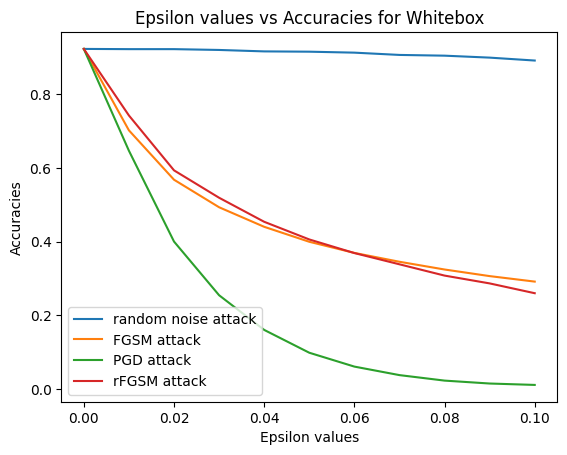

In [ ]:
plt.plot(epsilon_values, whitebox_Random,label = 'random noise attack')
plt.plot(epsilon_values, whitebox_FSGM,label = 'FGSM attack')
plt.plot(epsilon_values, whitebox_PGD,label = 'PGD attack')
plt.plot(epsilon_values, whitebox_rFSGM,label = 'rFGSM attack')
plt.xlabel('Epsilon values')
plt.ylabel('Accuracies')
plt.title('Epsilon values vs Accuracies for Whitebox')
plt.legend()
plt.show()

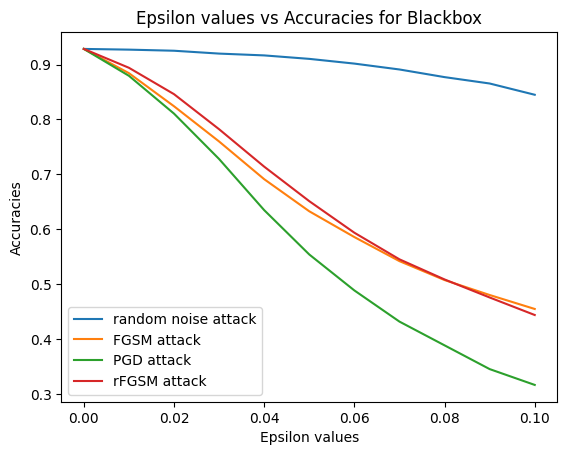

In [ ]:
plt.plot(epsilon_values, blackbox_Random,label = 'random noise attack')
plt.plot(epsilon_values, blackbox_FSGM,label = 'FGSM attack')
plt.plot(epsilon_values, blackbox_PGD,label = 'PGD attack')
plt.plot(epsilon_values, blackbox_rFSGM,label = 'rFGSM attack')
plt.xlabel('Epsilon values')
plt.ylabel('Accuracies')
plt.title('Epsilon values vs Accuracies for Blackbox')
plt.legend()
plt.show()

## Test Robust Models

Don't forget to plot accuracy vs. epsilon curves!

## FSGM

In [ ]:
## Pick a model architecture
net = models.NetA().to(device)
#net = models.NetB().to(device)

## Checkpoint name for this model
model_checkpoint = "netA_advtrain_fgsm0p1.pt"
#model_checkpoint = "netB_standard.pt"

## Basic training params
num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

FGSM_train_losses = []

## Training Loop
for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device); labels = labels.to(device)

        adv_data = attacks.FGSM_attack(net,device,data,labels,0.1)

        # Forward pass
        outputs = net(adv_data)
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)

    FGSM_train_losses.append(train_loss/len(train_loader))

    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    # Save model
    torch.save(net.state_dict(), model_checkpoint)

    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

Epoch: [ 0 / 20 ]; TrainAcc: 0.66312; TrainLoss: 0.82879; TestAcc: 0.79780; TestLoss: 0.49110
Epoch: [ 1 / 20 ]; TrainAcc: 0.78047; TrainLoss: 0.55237; TestAcc: 0.80160; TestLoss: 0.57294
Epoch: [ 2 / 20 ]; TrainAcc: 0.74370; TrainLoss: 0.63811; TestAcc: 0.82790; TestLoss: 0.44577
Epoch: [ 3 / 20 ]; TrainAcc: 0.82902; TrainLoss: 0.43938; TestAcc: 0.75600; TestLoss: 0.76110
Epoch: [ 4 / 20 ]; TrainAcc: 0.94118; TrainLoss: 0.16911; TestAcc: 0.56960; TestLoss: 4.40863
Epoch: [ 5 / 20 ]; TrainAcc: 0.88607; TrainLoss: 0.31873; TestAcc: 0.71960; TestLoss: 0.82078
Epoch: [ 6 / 20 ]; TrainAcc: 0.92192; TrainLoss: 0.23056; TestAcc: 0.75380; TestLoss: 0.76213
Epoch: [ 7 / 20 ]; TrainAcc: 0.92643; TrainLoss: 0.21220; TestAcc: 0.63930; TestLoss: 1.60984
Epoch: [ 8 / 20 ]; TrainAcc: 0.92492; TrainLoss: 0.22189; TestAcc: 0.70490; TestLoss: 0.83626
Epoch: [ 9 / 20 ]; TrainAcc: 0.94927; TrainLoss: 0.15327; TestAcc: 0.61490; TestLoss: 1.25251
Epoch: [ 10 / 20 ]; TrainAcc: 0.95467; TrainLoss: 0.13304; T

Text(0.5, 1.0, 'Loss curve for FGSM')

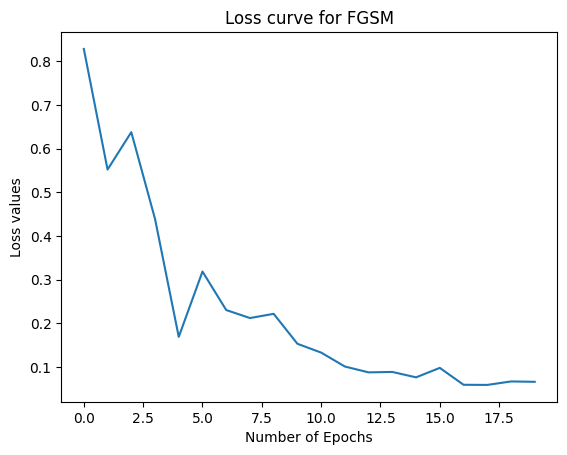

In [ ]:
plt.plot(np.arange(20),FGSM_train_losses)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss values')
plt.title('Loss curve for FGSM')

## rFSGM

In [ ]:
## Pick a model architecture
net = models.NetA().to(device)
#net = models.NetB().to(device)

## Checkpoint name for this model
model_checkpoint = "“netA_advtrain_rfgsm0p1.pt"
#model_checkpoint = "netB_standard.pt"

## Basic training params
num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

rFGSMtrain_losses = []

## Training Loop
for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device); labels = labels.to(device)

        adv_data = attacks.rFGSM_attack(net,device,data,labels,0.1)

        # Forward pass
        outputs = net(adv_data)
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)

    rFGSMtrain_losses.append(train_loss/len(train_loader))

    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    # Save model
    torch.save(net.state_dict(), model_checkpoint)

    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

Epoch: [ 0 / 20 ]; TrainAcc: 0.68797; TrainLoss: 0.77647; TestAcc: 0.83390; TestLoss: 0.43876
Epoch: [ 1 / 20 ]; TrainAcc: 0.75637; TrainLoss: 0.61059; TestAcc: 0.84420; TestLoss: 0.41100
Epoch: [ 2 / 20 ]; TrainAcc: 0.77305; TrainLoss: 0.56361; TestAcc: 0.84600; TestLoss: 0.39760
Epoch: [ 3 / 20 ]; TrainAcc: 0.78620; TrainLoss: 0.53009; TestAcc: 0.85220; TestLoss: 0.38348
Epoch: [ 4 / 20 ]; TrainAcc: 0.79658; TrainLoss: 0.50306; TestAcc: 0.85740; TestLoss: 0.36985
Epoch: [ 5 / 20 ]; TrainAcc: 0.80402; TrainLoss: 0.48528; TestAcc: 0.86120; TestLoss: 0.35435
Epoch: [ 6 / 20 ]; TrainAcc: 0.80897; TrainLoss: 0.47057; TestAcc: 0.86450; TestLoss: 0.34499
Epoch: [ 7 / 20 ]; TrainAcc: 0.81470; TrainLoss: 0.46037; TestAcc: 0.86720; TestLoss: 0.34675
Epoch: [ 8 / 20 ]; TrainAcc: 0.81722; TrainLoss: 0.45002; TestAcc: 0.86590; TestLoss: 0.33864
Epoch: [ 9 / 20 ]; TrainAcc: 0.82062; TrainLoss: 0.44055; TestAcc: 0.87130; TestLoss: 0.33905
Epoch: [ 10 / 20 ]; TrainAcc: 0.82562; TrainLoss: 0.43135; T

Text(0.5, 1.0, 'Loss curve for rFGSM')

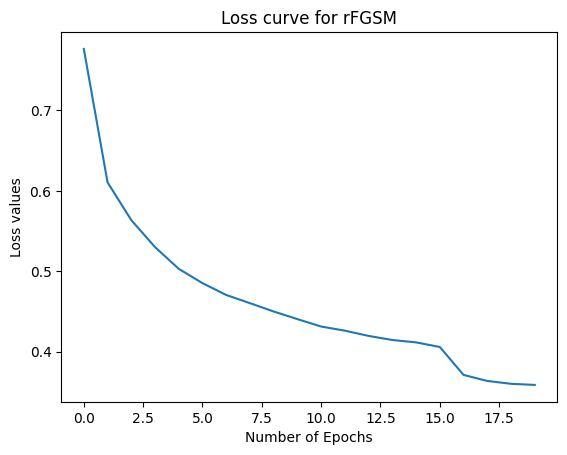

In [ ]:
plt.plot(np.arange(20),rFGSMtrain_losses)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss values')
plt.title('Loss curve for rFGSM')

## PGD


In [ ]:
## Pick a model architecture
net = models.NetA().to(device)
#net = models.NetB().to(device)

## Checkpoint name for this model
model_checkpoint = "netA_advtrain_pgd0p1.pt"
#model_checkpoint = "netB_standard.pt"

## Basic training params
num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

PGD_train_losses = []

EPS = 0.1
iTERS = 4
ALPHA = 1.85*(EPS/iTERS)
## Training Loop
for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device); labels = labels.to(device)

        adv_data = attacks.PGD_attack(net, device, data, labels, EPS, ALPHA, iTERS, True)

        # Forward pass
        outputs = net(adv_data)
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)

    PGD_train_losses.append(train_loss/len(train_loader))

    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    # Save model
    torch.save(net.state_dict(), model_checkpoint)

    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

Epoch: [ 0 / 20 ]; TrainAcc: 0.64870; TrainLoss: 0.86387; TestAcc: 0.82170; TestLoss: 0.49790
Epoch: [ 1 / 20 ]; TrainAcc: 0.72135; TrainLoss: 0.68200; TestAcc: 0.83370; TestLoss: 0.44579
Epoch: [ 2 / 20 ]; TrainAcc: 0.74652; TrainLoss: 0.62188; TestAcc: 0.83740; TestLoss: 0.43775
Epoch: [ 3 / 20 ]; TrainAcc: 0.76500; TrainLoss: 0.57902; TestAcc: 0.84600; TestLoss: 0.40067
Epoch: [ 4 / 20 ]; TrainAcc: 0.77470; TrainLoss: 0.55536; TestAcc: 0.84350; TestLoss: 0.40085
Epoch: [ 5 / 20 ]; TrainAcc: 0.77952; TrainLoss: 0.54157; TestAcc: 0.85180; TestLoss: 0.38466
Epoch: [ 6 / 20 ]; TrainAcc: 0.78473; TrainLoss: 0.53130; TestAcc: 0.85220; TestLoss: 0.38064
Epoch: [ 7 / 20 ]; TrainAcc: 0.78730; TrainLoss: 0.52189; TestAcc: 0.85020; TestLoss: 0.38105
Epoch: [ 8 / 20 ]; TrainAcc: 0.79000; TrainLoss: 0.51502; TestAcc: 0.85840; TestLoss: 0.37757
Epoch: [ 9 / 20 ]; TrainAcc: 0.79260; TrainLoss: 0.50931; TestAcc: 0.85670; TestLoss: 0.37055
Epoch: [ 10 / 20 ]; TrainAcc: 0.79365; TrainLoss: 0.50540; T

Text(0.5, 1.0, 'Loss curve for PGD')

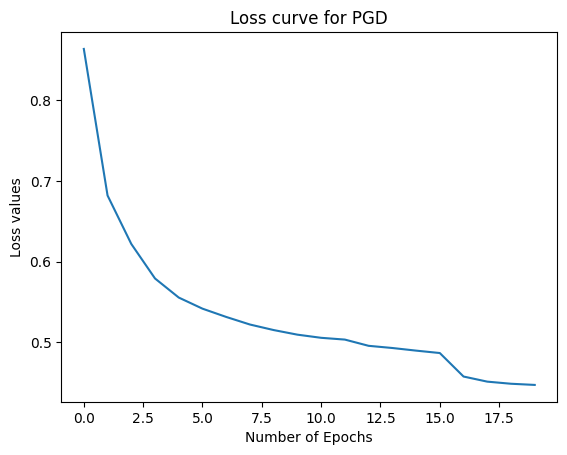

In [ ]:
plt.plot(np.arange(20),PGD_train_losses)
plt.xlabel('Number of Epochs')
plt.ylabel('Loss values')
plt.title('Loss curve for PGD')

In [14]:
def robust_models(EPS,attack_type,saved_model):
  whitebox = models.NetA()
  whitebox.load_state_dict(torch.load(saved_model)) # TODO: Load your robust models
  whitebox = whitebox.to(device)
  whitebox.eval();

  test_acc,_ = test_model(whitebox,test_loader,device)
  print("Initial Accuracy of Whitebox Model: ",test_acc)

  ## Test the model against an adversarial attack

  # TODO: Set attack parameters here
  ATK_EPS = eps
  ATK_ITERS = 10
  ATK_ALPHA = 1.85*(ATK_EPS/ATK_ITERS)

  whitebox_correct = 0.
  running_total = 0.
  for batch_idx,(data,labels) in enumerate(test_loader):
      data = data.to(device)
      labels = labels.to(device)

      # TODO: Perform adversarial attack here
      if attack_type == 'random_noise':
        adv_data = attacks.random_noise_attack(whitebox,device,data,ATK_EPS)
      elif attack_type == 'FGSM':
        adv_data = attacks.FGSM_attack(whitebox,device,data,labels,ATK_EPS)
      elif attack_type == 'rFGSM':
        adv_data = attacks.rFGSM_attack(whitebox,device,data,labels,ATK_EPS)
      elif attack_type == 'PGD':
        adv_data = attacks.PGD_attack(net, device, data, labels, ATK_EPS, ATK_ALPHA, ATK_ITERS, rand_start = True)


      # Sanity checking if adversarial example is "legal"
      assert(torch.max(torch.abs(adv_data-data)) <= (ATK_EPS + 1e-5) )
      assert(adv_data.max() == 1.)
      assert(adv_data.min() == 0.)

      # Compute accuracy on perturbed data
      with torch.no_grad():
          whitebox_outputs = whitebox(adv_data)
          _,whitebox_preds = whitebox_outputs.max(1)
          whitebox_correct += whitebox_preds.eq(labels).sum().item()
          running_total += labels.size(0)

  # Print final
  whitebox_acc = whitebox_correct/running_total
  print("Attack Epsilon: {}; Whitebox Accuracy: {}".format(ATK_EPS, whitebox_acc))

  print("Done!")

  return whitebox_acc


In [ ]:
epsilon_values = [0,0.02,0.04,0.06,0.08,0.10,0.12,0.14]
FGSM_FGSM_accuracies = []
for eps in epsilon_values:
  FGSM_FGSM_acc = robust_models(eps,'FGSM','netA_advtrain_fgsm0p1.pt')
  FGSM_FGSM_accuracies.append(FGSM_FGSM_acc)

Initial Accuracy of Whitebox Model:  0.8753
Attack Epsilon: 0; Whitebox Accuracy: 0.8753
Done!
Initial Accuracy of Whitebox Model:  0.8753
Attack Epsilon: 0.02; Whitebox Accuracy: 0.8517
Done!
Initial Accuracy of Whitebox Model:  0.8753
Attack Epsilon: 0.04; Whitebox Accuracy: 0.8367
Done!
Initial Accuracy of Whitebox Model:  0.8753
Attack Epsilon: 0.06; Whitebox Accuracy: 0.8303
Done!
Initial Accuracy of Whitebox Model:  0.8753
Attack Epsilon: 0.08; Whitebox Accuracy: 0.8292
Done!
Initial Accuracy of Whitebox Model:  0.8753
Attack Epsilon: 0.1; Whitebox Accuracy: 0.83
Done!
Initial Accuracy of Whitebox Model:  0.8753
Attack Epsilon: 0.12; Whitebox Accuracy: 0.6866
Done!
Initial Accuracy of Whitebox Model:  0.8753
Attack Epsilon: 0.14; Whitebox Accuracy: 0.5971
Done!


In [ ]:
epsilon_values = [0,0.02,0.04,0.06,0.08,0.10,0.12,0.14]
FGSM_RFGSM_accuracies= []
for eps in epsilon_values:
  FGSM_RFGSM_acc = robust_models(eps,'rFGSM','netA_advtrain_fgsm0p1.pt')
  FGSM_RFGSM_accuracies.append(FGSM_RFGSM_acc)


Initial Accuracy of Whitebox Model:  0.8753
Attack Epsilon: 0; Whitebox Accuracy: 0.8753
Done!
Initial Accuracy of Whitebox Model:  0.8753
Attack Epsilon: 0.02; Whitebox Accuracy: 0.8545
Done!
Initial Accuracy of Whitebox Model:  0.8753
Attack Epsilon: 0.04; Whitebox Accuracy: 0.8416
Done!
Initial Accuracy of Whitebox Model:  0.8753
Attack Epsilon: 0.06; Whitebox Accuracy: 0.8325
Done!
Initial Accuracy of Whitebox Model:  0.8753
Attack Epsilon: 0.08; Whitebox Accuracy: 0.8274
Done!
Initial Accuracy of Whitebox Model:  0.8753
Attack Epsilon: 0.1; Whitebox Accuracy: 0.8183
Done!
Initial Accuracy of Whitebox Model:  0.8753
Attack Epsilon: 0.12; Whitebox Accuracy: 0.6765
Done!
Initial Accuracy of Whitebox Model:  0.8753
Attack Epsilon: 0.14; Whitebox Accuracy: 0.5567
Done!


In [ ]:
epsilon_values = [0,0.02,0.04,0.06,0.08,0.10,0.12,0.14]
FGSM_PGD_accuracies = []
for eps in epsilon_values:
  PGD_FGSM_acc = robust_models(eps,'PGD','netA_advtrain_fgsm0p1.pt')
  FGSM_PGD_accuracies.append(PGD_FGSM_acc)

Initial Accuracy of Whitebox Model:  0.8753
Attack Epsilon: 0; Whitebox Accuracy: 0.8753
Done!
Initial Accuracy of Whitebox Model:  0.8753
Attack Epsilon: 0.02; Whitebox Accuracy: 0.8645
Done!
Initial Accuracy of Whitebox Model:  0.8753
Attack Epsilon: 0.04; Whitebox Accuracy: 0.852
Done!
Initial Accuracy of Whitebox Model:  0.8753
Attack Epsilon: 0.06; Whitebox Accuracy: 0.8382
Done!
Initial Accuracy of Whitebox Model:  0.8753
Attack Epsilon: 0.08; Whitebox Accuracy: 0.8261
Done!
Initial Accuracy of Whitebox Model:  0.8753
Attack Epsilon: 0.1; Whitebox Accuracy: 0.8114
Done!
Initial Accuracy of Whitebox Model:  0.8753
Attack Epsilon: 0.12; Whitebox Accuracy: 0.4746
Done!
Initial Accuracy of Whitebox Model:  0.8753
Attack Epsilon: 0.14; Whitebox Accuracy: 0.2877
Done!


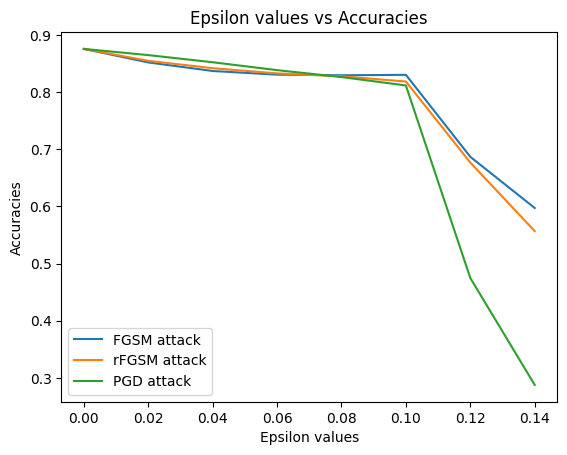

In [ ]:
plt.plot(epsilon_values, FGSM_FGSM_accuracies,label = 'FGSM attack')
plt.plot(epsilon_values, FGSM_RFGSM_accuracies,label = 'rFGSM attack')
plt.plot(epsilon_values, FGSM_PGD_accuracies,label = 'PGD attack')
plt.xlabel('Epsilon values')
plt.ylabel('Accuracies')
plt.title('Epsilon values vs Accuracies')
plt.legend()
plt.show()

In [ ]:
!ls

attacks.py  HWK5_main.ipynb  netA_advtrain_fgsm0p1.pt  “netA_advtrain_rfgsm0p1.pt  netB_standard.pt
data	    models.py	     netA_advtrain_pgd0p1.pt   netA_standard.pt		   __pycache__


In [ ]:
epsilon_values = [0,0.02,0.04,0.06,0.08,0.10,0.12,0.14]
RFGSM_FGSM_accuracies = []
for eps in epsilon_values:
  RFGSM_FGSM_acc = robust_models(eps,'FGSM','“netA_advtrain_rfgsm0p1.pt')
  RFGSM_FGSM_accuracies.append(RFGSM_FGSM_acc)

Initial Accuracy of Whitebox Model:  0.8854
Attack Epsilon: 0; Whitebox Accuracy: 0.8854
Done!
Initial Accuracy of Whitebox Model:  0.8854
Attack Epsilon: 0.02; Whitebox Accuracy: 0.8636
Done!
Initial Accuracy of Whitebox Model:  0.8854
Attack Epsilon: 0.04; Whitebox Accuracy: 0.8469
Done!
Initial Accuracy of Whitebox Model:  0.8854
Attack Epsilon: 0.06; Whitebox Accuracy: 0.8304
Done!
Initial Accuracy of Whitebox Model:  0.8854
Attack Epsilon: 0.08; Whitebox Accuracy: 0.8177
Done!
Initial Accuracy of Whitebox Model:  0.8854
Attack Epsilon: 0.1; Whitebox Accuracy: 0.8054
Done!
Initial Accuracy of Whitebox Model:  0.8854
Attack Epsilon: 0.12; Whitebox Accuracy: 0.7782
Done!
Initial Accuracy of Whitebox Model:  0.8854
Attack Epsilon: 0.14; Whitebox Accuracy: 0.6344
Done!


In [ ]:
epsilon_values = [0,0.02,0.04,0.06,0.08,0.10,0.12,0.14]
RFGSM_RFGSM_accuracies = []
for eps in epsilon_values:
  RFGSM_RFGSM_acc = robust_models(eps,'rFGSM','“netA_advtrain_rfgsm0p1.pt')
  RFGSM_RFGSM_accuracies.append(RFGSM_RFGSM_acc)

Initial Accuracy of Whitebox Model:  0.8854
Attack Epsilon: 0; Whitebox Accuracy: 0.8854
Done!
Initial Accuracy of Whitebox Model:  0.8854
Attack Epsilon: 0.02; Whitebox Accuracy: 0.8681
Done!
Initial Accuracy of Whitebox Model:  0.8854
Attack Epsilon: 0.04; Whitebox Accuracy: 0.8544
Done!
Initial Accuracy of Whitebox Model:  0.8854
Attack Epsilon: 0.06; Whitebox Accuracy: 0.8415
Done!
Initial Accuracy of Whitebox Model:  0.8854
Attack Epsilon: 0.08; Whitebox Accuracy: 0.8302
Done!
Initial Accuracy of Whitebox Model:  0.8854
Attack Epsilon: 0.1; Whitebox Accuracy: 0.8187
Done!
Initial Accuracy of Whitebox Model:  0.8854
Attack Epsilon: 0.12; Whitebox Accuracy: 0.747
Done!
Initial Accuracy of Whitebox Model:  0.8854
Attack Epsilon: 0.14; Whitebox Accuracy: 0.5159
Done!


In [ ]:
epsilon_values = [0,0.02,0.04,0.06,0.08,0.10,0.12,0.14]
RFGSM_PGD_accuracies = []
for eps in epsilon_values:
  RFGSM_PGD_acc = robust_models(eps,'PGD','“netA_advtrain_rfgsm0p1.pt')
  RFGSM_PGD_accuracies.append(RFGSM_PGD_acc)

Initial Accuracy of Whitebox Model:  0.8854
Attack Epsilon: 0; Whitebox Accuracy: 0.8854
Done!
Initial Accuracy of Whitebox Model:  0.8854
Attack Epsilon: 0.02; Whitebox Accuracy: 0.8744
Done!
Initial Accuracy of Whitebox Model:  0.8854
Attack Epsilon: 0.04; Whitebox Accuracy: 0.8607
Done!
Initial Accuracy of Whitebox Model:  0.8854
Attack Epsilon: 0.06; Whitebox Accuracy: 0.8482
Done!
Initial Accuracy of Whitebox Model:  0.8854
Attack Epsilon: 0.08; Whitebox Accuracy: 0.8337
Done!
Initial Accuracy of Whitebox Model:  0.8854
Attack Epsilon: 0.1; Whitebox Accuracy: 0.8166
Done!
Initial Accuracy of Whitebox Model:  0.8854
Attack Epsilon: 0.12; Whitebox Accuracy: 0.6575
Done!
Initial Accuracy of Whitebox Model:  0.8854
Attack Epsilon: 0.14; Whitebox Accuracy: 0.3629
Done!


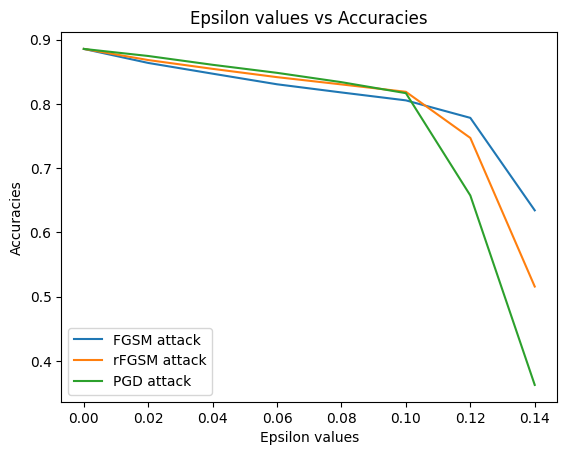

In [ ]:
plt.plot(epsilon_values, RFGSM_FGSM_accuracies,label = 'FGSM attack')
plt.plot(epsilon_values, RFGSM_RFGSM_accuracies,label = 'rFGSM attack')
plt.plot(epsilon_values, RFGSM_PGD_accuracies,label = 'PGD attack')
plt.xlabel('Epsilon values')
plt.ylabel('Accuracies')
plt.title('Epsilon values vs Accuracies')
plt.legend()
plt.show()

In [ ]:
epsilon_values = [0,0.02,0.04,0.06,0.08,0.10,0.12,0.14]
PGD_FGSM_accuracies = []
for eps in epsilon_values:
  PGD_FGSM_acc = robust_models(eps,'FGSM','netA_advtrain_pgd0p1.pt')
  PGD_FGSM_accuracies.append(PGD_FGSM_acc)

Initial Accuracy of Whitebox Model:  0.87
Attack Epsilon: 0; Whitebox Accuracy: 0.87
Done!
Initial Accuracy of Whitebox Model:  0.87
Attack Epsilon: 0.02; Whitebox Accuracy: 0.8554
Done!
Initial Accuracy of Whitebox Model:  0.87
Attack Epsilon: 0.04; Whitebox Accuracy: 0.8411
Done!
Initial Accuracy of Whitebox Model:  0.87
Attack Epsilon: 0.06; Whitebox Accuracy: 0.831
Done!
Initial Accuracy of Whitebox Model:  0.87
Attack Epsilon: 0.08; Whitebox Accuracy: 0.822
Done!
Initial Accuracy of Whitebox Model:  0.87
Attack Epsilon: 0.1; Whitebox Accuracy: 0.8109
Done!
Initial Accuracy of Whitebox Model:  0.87
Attack Epsilon: 0.12; Whitebox Accuracy: 0.8062
Done!
Initial Accuracy of Whitebox Model:  0.87
Attack Epsilon: 0.14; Whitebox Accuracy: 0.7817
Done!


In [ ]:
epsilon_values = [0,0.02,0.04,0.06,0.08,0.10,0.12,0.14]
PGD_RFGSM_accuracies = []
for eps in epsilon_values:
  PGD_RFGSM_acc = robust_models(eps,'rFGSM','netA_advtrain_pgd0p1.pt')
  PGD_RFGSM_accuracies.append(PGD_RFGSM_acc)

Initial Accuracy of Whitebox Model:  0.87
Attack Epsilon: 0; Whitebox Accuracy: 0.87
Done!
Initial Accuracy of Whitebox Model:  0.87
Attack Epsilon: 0.02; Whitebox Accuracy: 0.8586
Done!
Initial Accuracy of Whitebox Model:  0.87
Attack Epsilon: 0.04; Whitebox Accuracy: 0.8474
Done!
Initial Accuracy of Whitebox Model:  0.87
Attack Epsilon: 0.06; Whitebox Accuracy: 0.8393
Done!
Initial Accuracy of Whitebox Model:  0.87
Attack Epsilon: 0.08; Whitebox Accuracy: 0.8308
Done!
Initial Accuracy of Whitebox Model:  0.87
Attack Epsilon: 0.1; Whitebox Accuracy: 0.8243
Done!
Initial Accuracy of Whitebox Model:  0.87
Attack Epsilon: 0.12; Whitebox Accuracy: 0.7951
Done!
Initial Accuracy of Whitebox Model:  0.87
Attack Epsilon: 0.14; Whitebox Accuracy: 0.6544
Done!


In [ ]:
epsilon_values = [0,0.02,0.04,0.06,0.08,0.10,0.12,0.14]
PGD_PGD_accuracies = []
for eps in epsilon_values:
  PGD_PGD_acc = robust_models(eps,'PGD','netA_advtrain_pgd0p1.pt')
  PGD_PGD_accuracies.append(PGD_PGD_acc)

Initial Accuracy of Whitebox Model:  0.87
Attack Epsilon: 0; Whitebox Accuracy: 0.87
Done!
Initial Accuracy of Whitebox Model:  0.87
Attack Epsilon: 0.02; Whitebox Accuracy: 0.8538
Done!
Initial Accuracy of Whitebox Model:  0.87
Attack Epsilon: 0.04; Whitebox Accuracy: 0.8375
Done!
Initial Accuracy of Whitebox Model:  0.87
Attack Epsilon: 0.06; Whitebox Accuracy: 0.8213
Done!
Initial Accuracy of Whitebox Model:  0.87
Attack Epsilon: 0.08; Whitebox Accuracy: 0.8047
Done!
Initial Accuracy of Whitebox Model:  0.87
Attack Epsilon: 0.1; Whitebox Accuracy: 0.7842
Done!
Initial Accuracy of Whitebox Model:  0.87
Attack Epsilon: 0.12; Whitebox Accuracy: 0.6664
Done!
Initial Accuracy of Whitebox Model:  0.87
Attack Epsilon: 0.14; Whitebox Accuracy: 0.2929
Done!


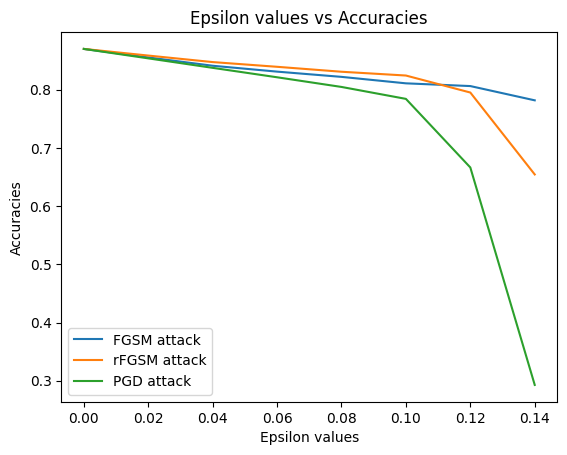

In [ ]:
plt.plot(epsilon_values, PGD_FGSM_accuracies,label = 'FGSM attack')
plt.plot(epsilon_values, PGD_RFGSM_accuracies,label = 'rFGSM attack')
plt.plot(epsilon_values, PGD_PGD_accuracies,label = 'PGD attack')
plt.xlabel('Epsilon values')
plt.ylabel('Accuracies')
plt.title('Epsilon values vs Accuracies')
plt.legend()
plt.show()

In [11]:
## Pick a model architecture
net = models.NetA().to(device)
#net = models.NetB().to(device)

## Checkpoint name for this model
model_checkpoint = "netA_advtrain_pgd0p1_e_0_2.pt"
#model_checkpoint = "netB_standard.pt"

## Basic training params
num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

pgd_train_losses = []
eps = 0.2
iters = 4
alpha = 1.85*(eps/iters)
## Training Loop
for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device); labels = labels.to(device)

        adv_data = attacks.PGD_attack(net, device, data, labels, eps, alpha, iters, True)

        # Forward pass
        outputs = net(adv_data)
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)

    pgd_train_losses.append(train_loss/len(train_loader))

    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    # Save model
    torch.save(net.state_dict(), model_checkpoint)

    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

Epoch: [ 0 / 20 ]; TrainAcc: 0.54327; TrainLoss: 1.12319; TestAcc: 0.76990; TestLoss: 0.58733
Epoch: [ 1 / 20 ]; TrainAcc: 0.67470; TrainLoss: 0.78255; TestAcc: 0.77420; TestLoss: 0.58659
Epoch: [ 2 / 20 ]; TrainAcc: 0.71048; TrainLoss: 0.70438; TestAcc: 0.81310; TestLoss: 0.50861
Epoch: [ 3 / 20 ]; TrainAcc: 0.73112; TrainLoss: 0.66219; TestAcc: 0.81790; TestLoss: 0.49324
Epoch: [ 4 / 20 ]; TrainAcc: 0.74522; TrainLoss: 0.63042; TestAcc: 0.81100; TestLoss: 0.48971
Epoch: [ 5 / 20 ]; TrainAcc: 0.75097; TrainLoss: 0.61127; TestAcc: 0.82480; TestLoss: 0.46145
Epoch: [ 6 / 20 ]; TrainAcc: 0.75697; TrainLoss: 0.59759; TestAcc: 0.81820; TestLoss: 0.45747
Epoch: [ 7 / 20 ]; TrainAcc: 0.76235; TrainLoss: 0.58569; TestAcc: 0.82790; TestLoss: 0.45487
Epoch: [ 8 / 20 ]; TrainAcc: 0.76627; TrainLoss: 0.57618; TestAcc: 0.83570; TestLoss: 0.44109
Epoch: [ 9 / 20 ]; TrainAcc: 0.76895; TrainLoss: 0.56830; TestAcc: 0.83440; TestLoss: 0.44248
Epoch: [ 10 / 20 ]; TrainAcc: 0.77385; TrainLoss: 0.55939; T

In [12]:
## Pick a model architecture
net = models.NetA().to(device)
#net = models.NetB().to(device)

## Checkpoint name for this model
model_checkpoint = "netA_advtrain_pgd0p1_e_0_05.pt"
#model_checkpoint = "netB_standard.pt"

## Basic training params
num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

pgd_train_losses = []
eps = 0.05
iters = 4
alpha = 1.85*(eps/iters)
## Training Loop
for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device); labels = labels.to(device)

        adv_data = attacks.PGD_attack(net, device, data, labels, eps, alpha, iters, True)

        # Forward pass
        outputs = net(adv_data)
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)

    pgd_train_losses.append(train_loss/len(train_loader))

    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    # Save model
    torch.save(net.state_dict(), model_checkpoint)

    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

Epoch: [ 0 / 20 ]; TrainAcc: 0.72513; TrainLoss: 0.68704; TestAcc: 0.85230; TestLoss: 0.40278
Epoch: [ 1 / 20 ]; TrainAcc: 0.78437; TrainLoss: 0.53930; TestAcc: 0.85140; TestLoss: 0.37876
Epoch: [ 2 / 20 ]; TrainAcc: 0.79920; TrainLoss: 0.50070; TestAcc: 0.86160; TestLoss: 0.35145
Epoch: [ 3 / 20 ]; TrainAcc: 0.80783; TrainLoss: 0.47423; TestAcc: 0.87500; TestLoss: 0.33416
Epoch: [ 4 / 20 ]; TrainAcc: 0.81705; TrainLoss: 0.45496; TestAcc: 0.87300; TestLoss: 0.33884
Epoch: [ 5 / 20 ]; TrainAcc: 0.82160; TrainLoss: 0.44121; TestAcc: 0.87930; TestLoss: 0.32370
Epoch: [ 6 / 20 ]; TrainAcc: 0.82585; TrainLoss: 0.42886; TestAcc: 0.87800; TestLoss: 0.32318
Epoch: [ 7 / 20 ]; TrainAcc: 0.82967; TrainLoss: 0.42064; TestAcc: 0.87750; TestLoss: 0.31653
Epoch: [ 8 / 20 ]; TrainAcc: 0.83258; TrainLoss: 0.41099; TestAcc: 0.87700; TestLoss: 0.31735
Epoch: [ 9 / 20 ]; TrainAcc: 0.83453; TrainLoss: 0.40641; TestAcc: 0.87830; TestLoss: 0.31931
Epoch: [ 10 / 20 ]; TrainAcc: 0.83670; TrainLoss: 0.40034; T

In [13]:
## Pick a model architecture
net = models.NetA().to(device)
#net = models.NetB().to(device)

## Checkpoint name for this model
model_checkpoint = "netA_advtrain_pgd0p1_e_0_15.pt"
#model_checkpoint = "netB_standard.pt"

## Basic training params
num_epochs = 20
initial_lr = 0.001
lr_decay_epoch = 15

optimizer = torch.optim.Adam(net.parameters(), lr=initial_lr)

pgd_train_losses = []
eps = 0.15
iters = 4
alpha = 1.85*(eps/iters)
## Training Loop
for epoch in range(num_epochs):
    net.train()
    train_correct = 0.
    train_loss = 0.
    train_total = 0.
    for batch_idx,(data,labels) in enumerate(train_loader):
        data = data.to(device); labels = labels.to(device)

        adv_data = attacks.PGD_attack(net, device, data, labels, eps, alpha, iters, True)

        # Forward pass
        outputs = net(adv_data)
        net.zero_grad()
        optimizer.zero_grad()
        # Compute loss, gradients, and update params
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        # Update stats
        _,preds = outputs.max(1)
        train_correct += preds.eq(labels).sum().item()
        train_loss += loss.item()
        train_total += labels.size(0)

    pgd_train_losses.append(train_loss/len(train_loader))

    # End of training epoch
    test_acc,test_loss = test_model(net,test_loader,device)
    print("Epoch: [ {} / {} ]; TrainAcc: {:.5f}; TrainLoss: {:.5f}; TestAcc: {:.5f}; TestLoss: {:.5f}".format(
        epoch, num_epochs, train_correct/train_total, train_loss/len(train_loader),
        test_acc, test_loss,
    ))
    # Save model
    torch.save(net.state_dict(), model_checkpoint)

    # Update LR
    if epoch == lr_decay_epoch:
        for param_group in optimizer.param_groups:
            param_group['lr'] = initial_lr*0.1

print("Done!")

Epoch: [ 0 / 20 ]; TrainAcc: 0.57562; TrainLoss: 1.05087; TestAcc: 0.77360; TestLoss: 0.57519
Epoch: [ 1 / 20 ]; TrainAcc: 0.67083; TrainLoss: 0.80389; TestAcc: 0.78350; TestLoss: 0.53267
Epoch: [ 2 / 20 ]; TrainAcc: 0.70230; TrainLoss: 0.71779; TestAcc: 0.81380; TestLoss: 0.51414
Epoch: [ 3 / 20 ]; TrainAcc: 0.72278; TrainLoss: 0.66861; TestAcc: 0.79650; TestLoss: 0.49602
Epoch: [ 4 / 20 ]; TrainAcc: 0.73600; TrainLoss: 0.63793; TestAcc: 0.81770; TestLoss: 0.47201
Epoch: [ 5 / 20 ]; TrainAcc: 0.74385; TrainLoss: 0.61717; TestAcc: 0.82140; TestLoss: 0.46384
Epoch: [ 6 / 20 ]; TrainAcc: 0.74913; TrainLoss: 0.60179; TestAcc: 0.82450; TestLoss: 0.46529
Epoch: [ 7 / 20 ]; TrainAcc: 0.75552; TrainLoss: 0.59137; TestAcc: 0.82740; TestLoss: 0.45300
Epoch: [ 8 / 20 ]; TrainAcc: 0.76002; TrainLoss: 0.57849; TestAcc: 0.83230; TestLoss: 0.44171
Epoch: [ 9 / 20 ]; TrainAcc: 0.76573; TrainLoss: 0.56980; TestAcc: 0.83150; TestLoss: 0.43672
Epoch: [ 10 / 20 ]; TrainAcc: 0.76850; TrainLoss: 0.56083; T

In [17]:
epsilon_values = [0,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16,0.18,0.2]
PGD_PGD_accuracies = []
for eps in epsilon_values:
  PGD_PGD_acc = robust_models(eps,'PGD','netA_advtrain_pgd0p1_e_0_05.pt')
  PGD_PGD_accuracies.append(PGD_PGD_acc)

PGD_RFGSM_accuracies= []
for eps in epsilon_values:
  PGD_RFGSM_acc = robust_models(eps,'rFGSM','netA_advtrain_pgd0p1_e_0_05.pt')
  PGD_RFGSM_accuracies.append(PGD_RFGSM_acc)

PGD_FGSM_accuracies = []
for eps in epsilon_values:
  PGD_FGSM_acc = robust_models(eps,'FGSM','netA_advtrain_pgd0p1_e_0_05.pt')
  PGD_FGSM_accuracies.append(PGD_FGSM_acc)

Initial Accuracy of Whitebox Model:  0.897
Attack Epsilon: 0; Whitebox Accuracy: 0.897
Done!
Initial Accuracy of Whitebox Model:  0.897
Attack Epsilon: 0.02; Whitebox Accuracy: 0.8919
Done!
Initial Accuracy of Whitebox Model:  0.897
Attack Epsilon: 0.04; Whitebox Accuracy: 0.8869
Done!
Initial Accuracy of Whitebox Model:  0.897
Attack Epsilon: 0.06; Whitebox Accuracy: 0.8811
Done!
Initial Accuracy of Whitebox Model:  0.897
Attack Epsilon: 0.08; Whitebox Accuracy: 0.8699
Done!
Initial Accuracy of Whitebox Model:  0.897
Attack Epsilon: 0.1; Whitebox Accuracy: 0.8578
Done!
Initial Accuracy of Whitebox Model:  0.897
Attack Epsilon: 0.12; Whitebox Accuracy: 0.8353
Done!
Initial Accuracy of Whitebox Model:  0.897
Attack Epsilon: 0.14; Whitebox Accuracy: 0.7807
Done!
Initial Accuracy of Whitebox Model:  0.897
Attack Epsilon: 0.16; Whitebox Accuracy: 0.6488
Done!
Initial Accuracy of Whitebox Model:  0.897
Attack Epsilon: 0.18; Whitebox Accuracy: 0.3432
Done!
Initial Accuracy of Whitebox Model:

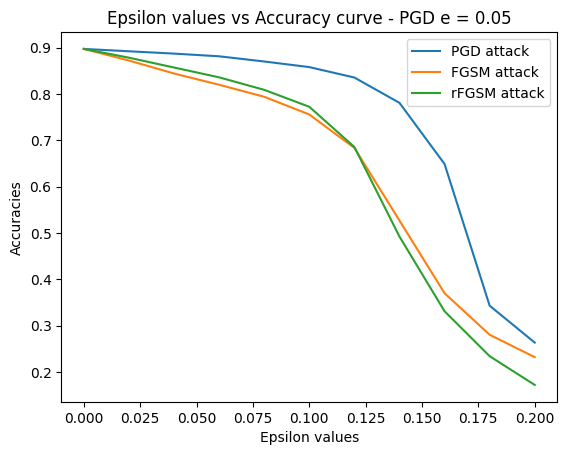

In [18]:
plt.plot(epsilon_values, PGD_PGD_accuracies,label = 'PGD attack')
plt.plot(epsilon_values, PGD_FGSM_accuracies,label = 'FGSM attack')
plt.plot(epsilon_values, PGD_RFGSM_accuracies,label = 'rFGSM attack')
plt.xlabel('Epsilon values')
plt.ylabel('Accuracies')
plt.title('Epsilon values vs Accuracy curve - PGD e = 0.05')
plt.legend()
plt.show()

In [19]:
epsilon_values = [0,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16,0.18,0.2]
PGD_PGD_accuracies = []
for eps in epsilon_values:
  PGD_PGD_acc = robust_models(eps,'PGD','netA_advtrain_pgd0p1_e_0_2.pt')
  PGD_PGD_accuracies.append(PGD_PGD_acc)

PGD_RFGSM_accuracies= []
for eps in epsilon_values:
  PGD_RFGSM_acc = robust_models(eps,'rFGSM','netA_advtrain_pgd0p1_e_0_2.pt')
  PGD_RFGSM_accuracies.append(PGD_RFGSM_acc)

PGD_FGSM_accuracies = []
for eps in epsilon_values:
  PGD_FGSM_acc = robust_models(eps,'FGSM','netA_advtrain_pgd0p1_e_0_2.pt')
  PGD_FGSM_accuracies.append(PGD_FGSM_acc)

Initial Accuracy of Whitebox Model:  0.8456
Attack Epsilon: 0; Whitebox Accuracy: 0.8456
Done!
Initial Accuracy of Whitebox Model:  0.8456
Attack Epsilon: 0.02; Whitebox Accuracy: 0.8416
Done!
Initial Accuracy of Whitebox Model:  0.8456
Attack Epsilon: 0.04; Whitebox Accuracy: 0.8354
Done!
Initial Accuracy of Whitebox Model:  0.8456
Attack Epsilon: 0.06; Whitebox Accuracy: 0.8305
Done!
Initial Accuracy of Whitebox Model:  0.8456
Attack Epsilon: 0.08; Whitebox Accuracy: 0.8267
Done!
Initial Accuracy of Whitebox Model:  0.8456
Attack Epsilon: 0.1; Whitebox Accuracy: 0.8219
Done!
Initial Accuracy of Whitebox Model:  0.8456
Attack Epsilon: 0.12; Whitebox Accuracy: 0.8168
Done!
Initial Accuracy of Whitebox Model:  0.8456
Attack Epsilon: 0.14; Whitebox Accuracy: 0.8088
Done!
Initial Accuracy of Whitebox Model:  0.8456
Attack Epsilon: 0.16; Whitebox Accuracy: 0.8049
Done!
Initial Accuracy of Whitebox Model:  0.8456
Attack Epsilon: 0.18; Whitebox Accuracy: 0.8098
Done!
Initial Accuracy of Whit

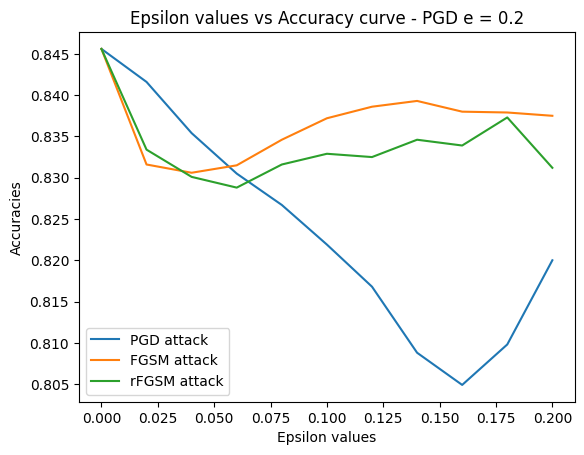

In [20]:
plt.plot(epsilon_values, PGD_PGD_accuracies,label = 'PGD attack')
plt.plot(epsilon_values, PGD_FGSM_accuracies,label = 'FGSM attack')
plt.plot(epsilon_values, PGD_RFGSM_accuracies,label = 'rFGSM attack')
plt.xlabel('Epsilon values')
plt.ylabel('Accuracies')
plt.title('Epsilon values vs Accuracy curve - PGD e = 0.2')
plt.legend()
plt.show()

In [21]:
epsilon_values = [0,0.02,0.04,0.06,0.08,0.10,0.12,0.14,0.16,0.18,0.2]
PGD_PGD_accuracies = []
for eps in epsilon_values:
  PGD_PGD_acc = robust_models(eps,'PGD','netA_advtrain_pgd0p1_e_0_15.pt')
  PGD_PGD_accuracies.append(PGD_PGD_acc)

PGD_RFGSM_accuracies= []
for eps in epsilon_values:
  PGD_RFGSM_acc = robust_models(eps,'rFGSM','netA_advtrain_pgd0p1_e_0_15.pt')
  PGD_RFGSM_accuracies.append(PGD_RFGSM_acc)

PGD_FGSM_accuracies = []
for eps in epsilon_values:
  PGD_FGSM_acc = robust_models(eps,'FGSM','netA_advtrain_pgd0p1_e_0_15.pt')
  PGD_FGSM_accuracies.append(PGD_FGSM_acc)

Initial Accuracy of Whitebox Model:  0.8418
Attack Epsilon: 0; Whitebox Accuracy: 0.8418
Done!
Initial Accuracy of Whitebox Model:  0.8418
Attack Epsilon: 0.02; Whitebox Accuracy: 0.8237
Done!
Initial Accuracy of Whitebox Model:  0.8418
Attack Epsilon: 0.04; Whitebox Accuracy: 0.8101
Done!
Initial Accuracy of Whitebox Model:  0.8418
Attack Epsilon: 0.06; Whitebox Accuracy: 0.8
Done!
Initial Accuracy of Whitebox Model:  0.8418
Attack Epsilon: 0.08; Whitebox Accuracy: 0.7889
Done!
Initial Accuracy of Whitebox Model:  0.8418
Attack Epsilon: 0.1; Whitebox Accuracy: 0.7778
Done!
Initial Accuracy of Whitebox Model:  0.8418
Attack Epsilon: 0.12; Whitebox Accuracy: 0.7692
Done!
Initial Accuracy of Whitebox Model:  0.8418
Attack Epsilon: 0.14; Whitebox Accuracy: 0.7575
Done!
Initial Accuracy of Whitebox Model:  0.8418
Attack Epsilon: 0.16; Whitebox Accuracy: 0.7366
Done!
Initial Accuracy of Whitebox Model:  0.8418
Attack Epsilon: 0.18; Whitebox Accuracy: 0.0701
Done!
Initial Accuracy of Whitebo

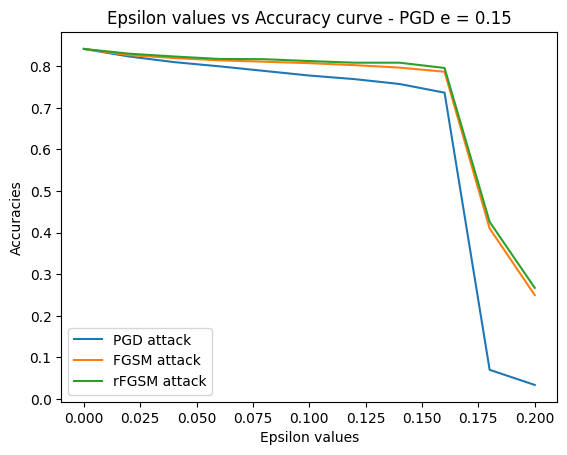

In [22]:
plt.plot(epsilon_values, PGD_PGD_accuracies,label = 'PGD attack')
plt.plot(epsilon_values, PGD_FGSM_accuracies,label = 'FGSM attack')
plt.plot(epsilon_values, PGD_RFGSM_accuracies,label = 'rFGSM attack')
plt.xlabel('Epsilon values')
plt.ylabel('Accuracies')
plt.title('Epsilon values vs Accuracy curve - PGD e = 0.15')
plt.legend()
plt.show()